In [1]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import *
from util import *
from util_fk import *
import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


In [2]:
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


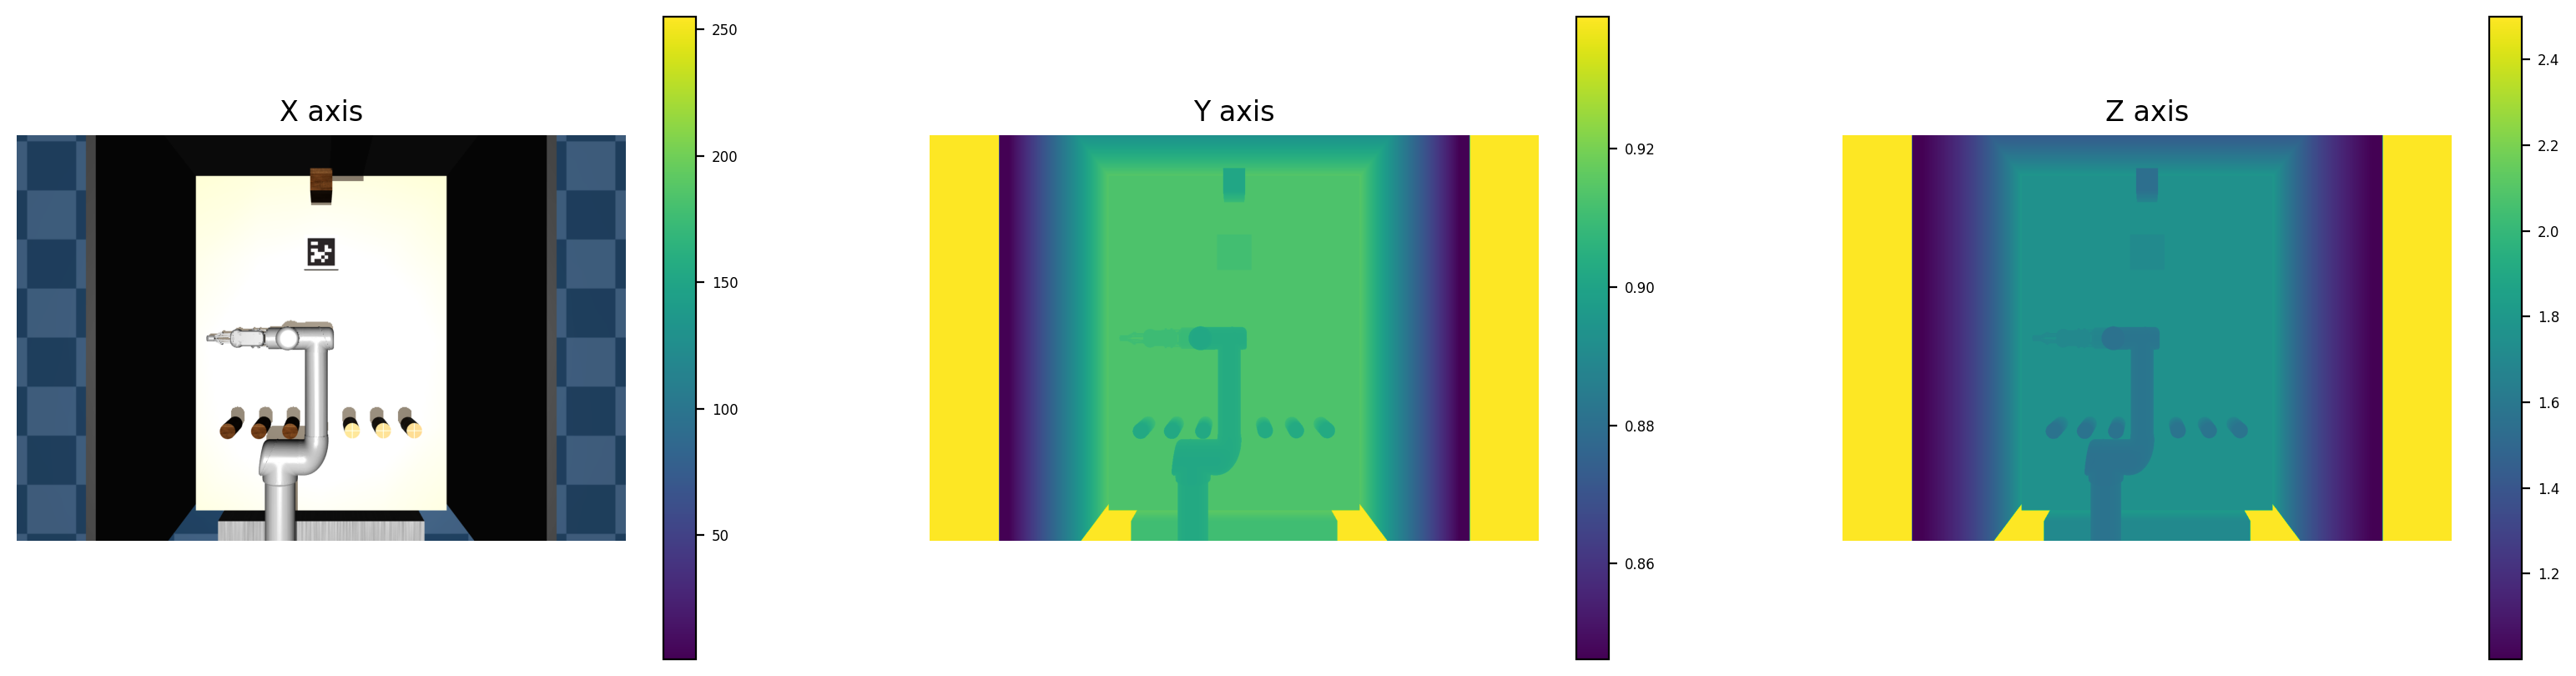

In [3]:
# Up-right table view.
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0,        # Z-axis: Yaw
                    cam_elevation = -90,      # X-axis: Roll                        
                    cam_lookat    = [1.0, 0.0, 2.5])  # arbitrary offset on camera.

# update object, robot configurations
env.forward(INCREASE_TICK=False)

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
    img_real = np.array(env.depth2meters(img_depth))

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(img); plt.axis('off')
plt.title("X axis")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(img_depth); plt.axis('off')
plt.title("Y axis")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(img_real); plt.axis('off')
plt.title("Z axis")
plt.colorbar()
plt.show()

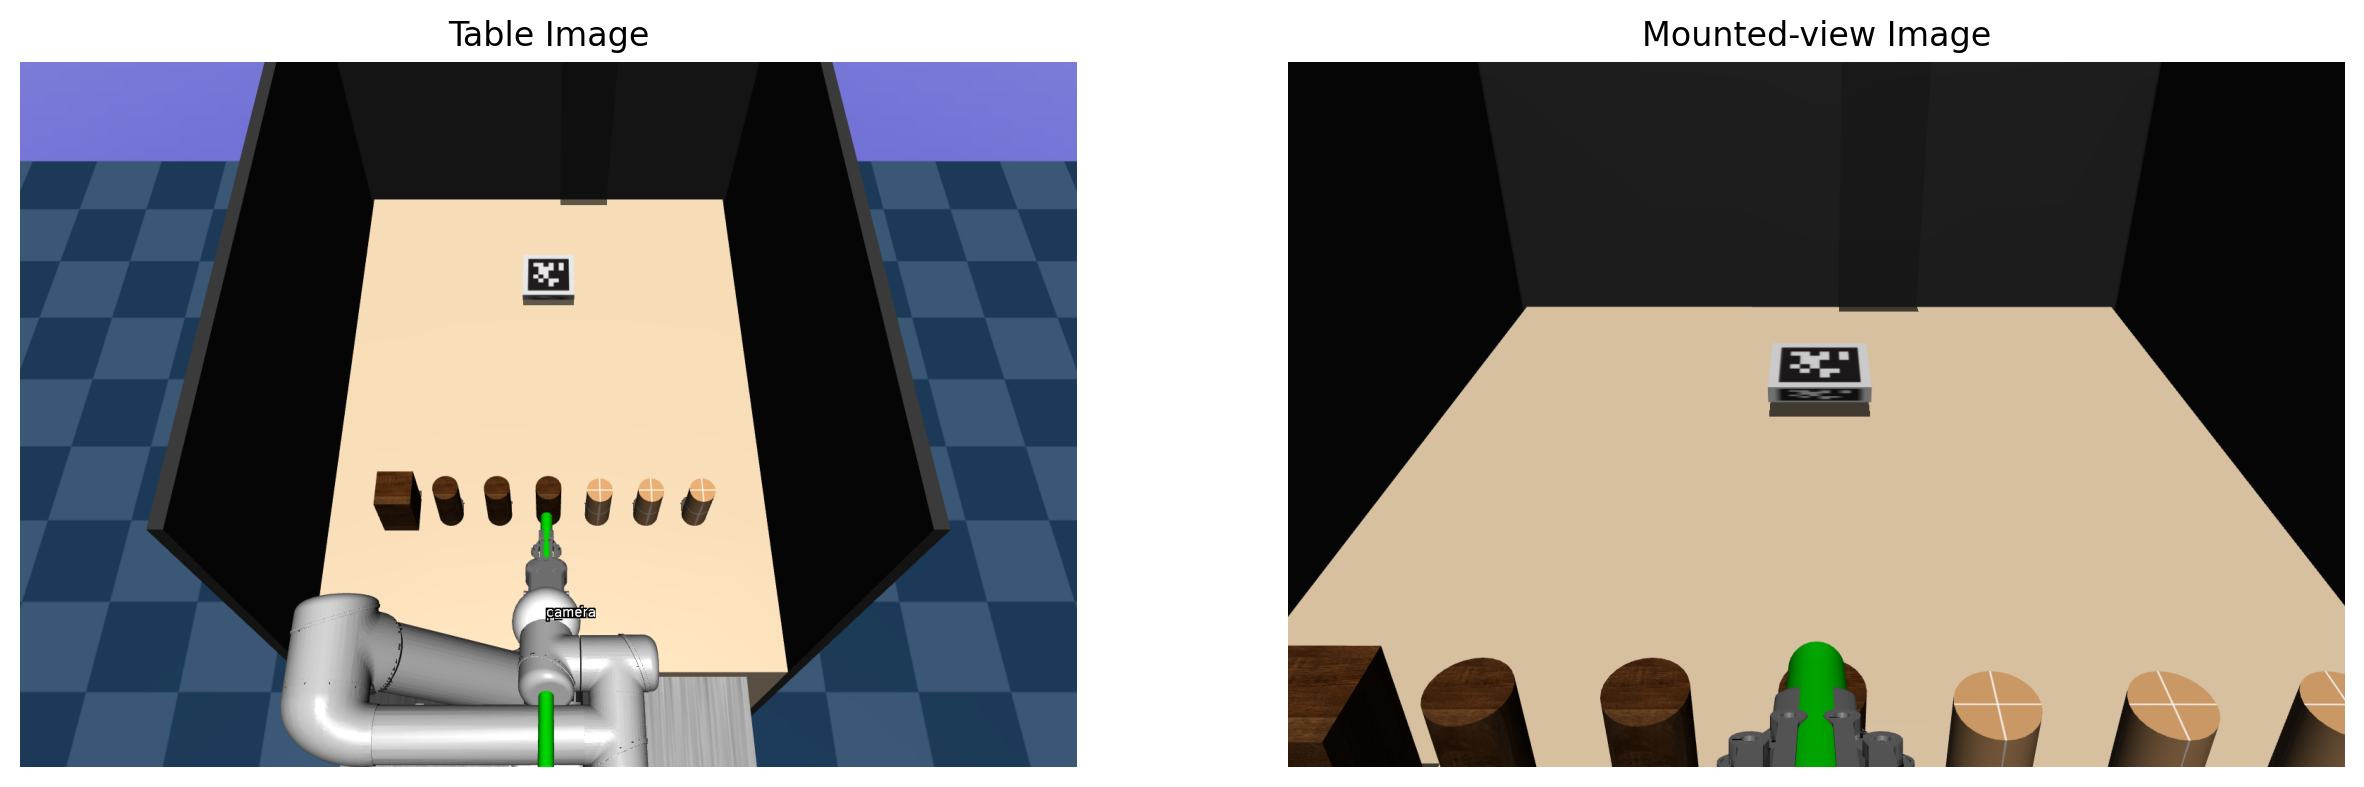

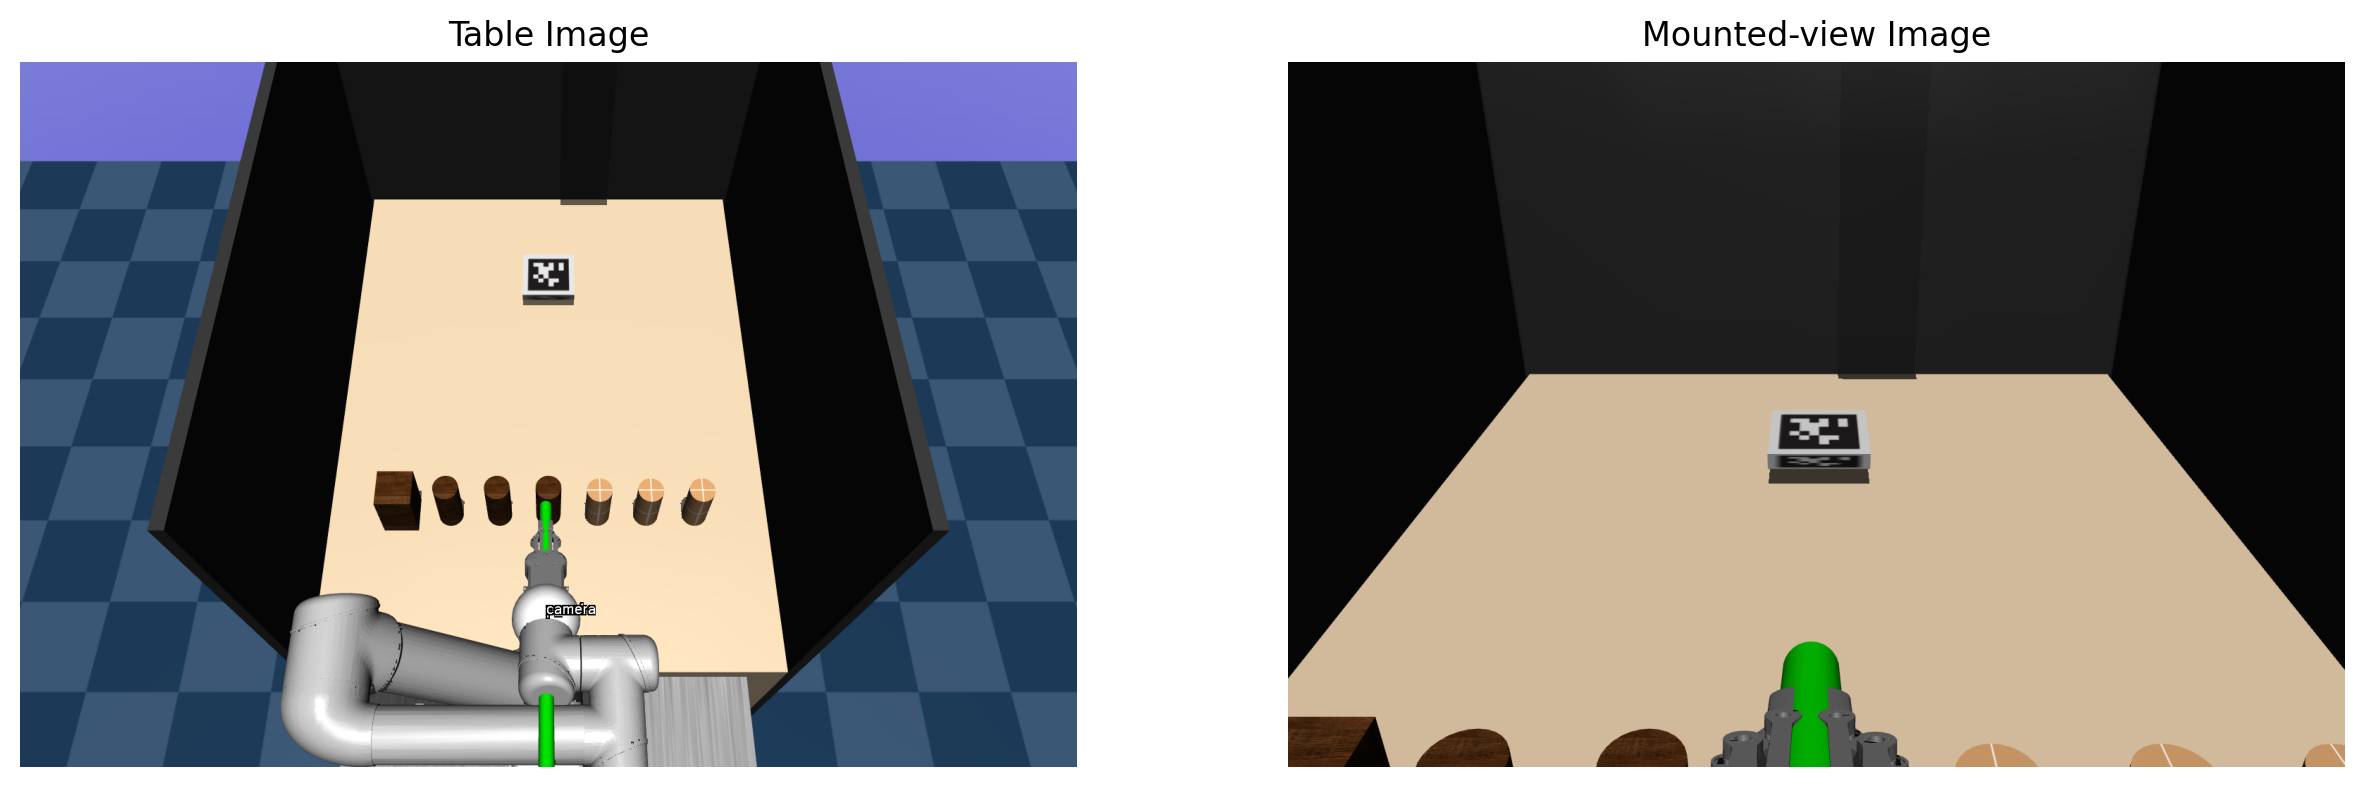

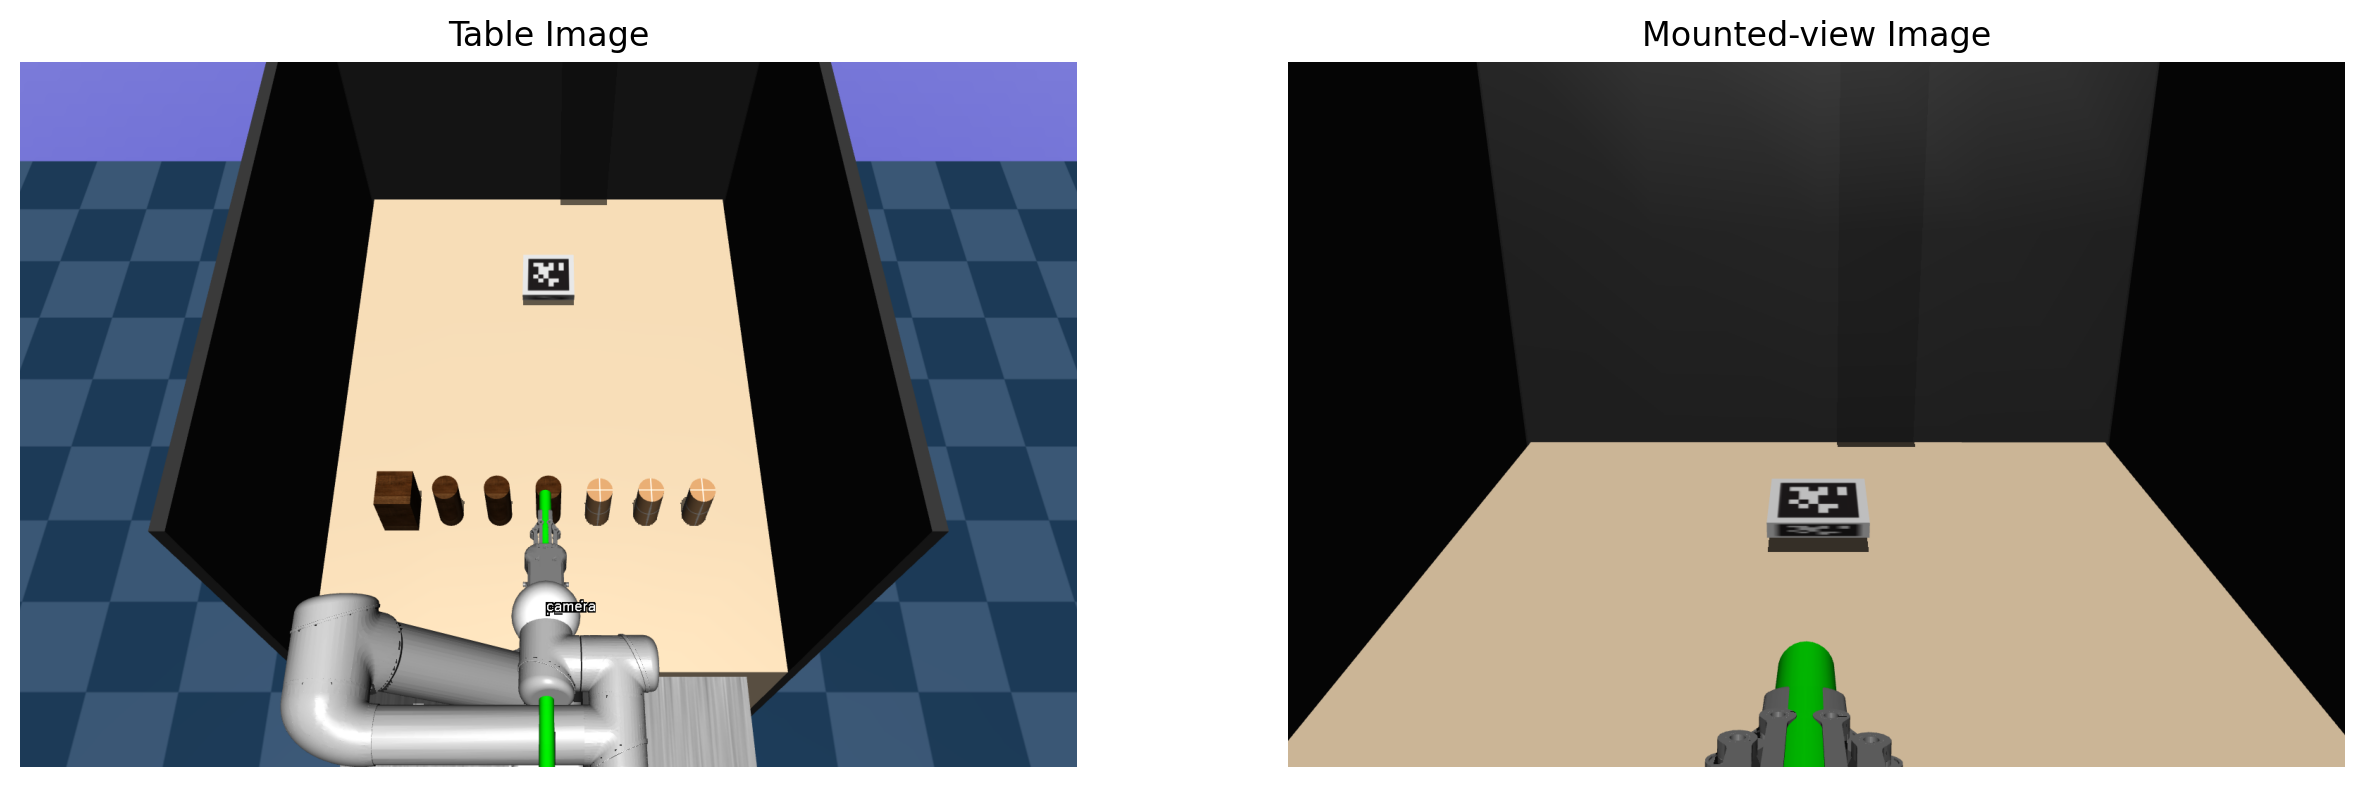

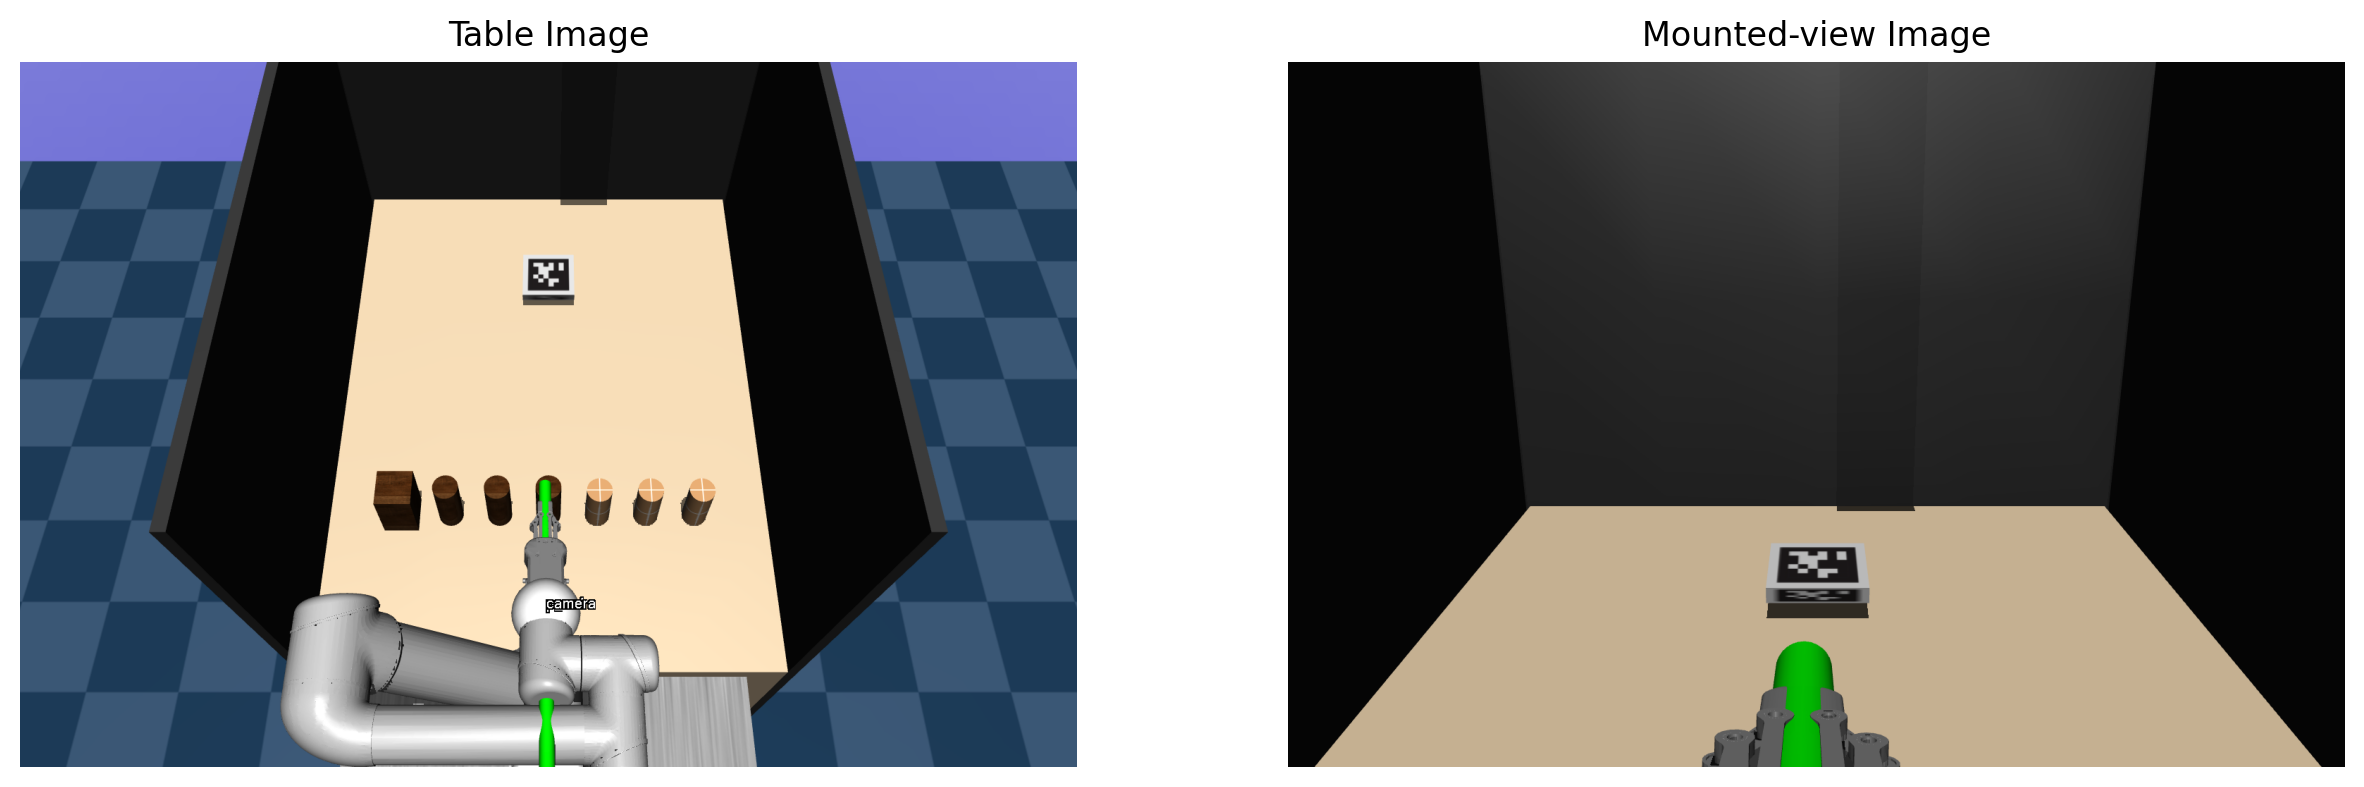

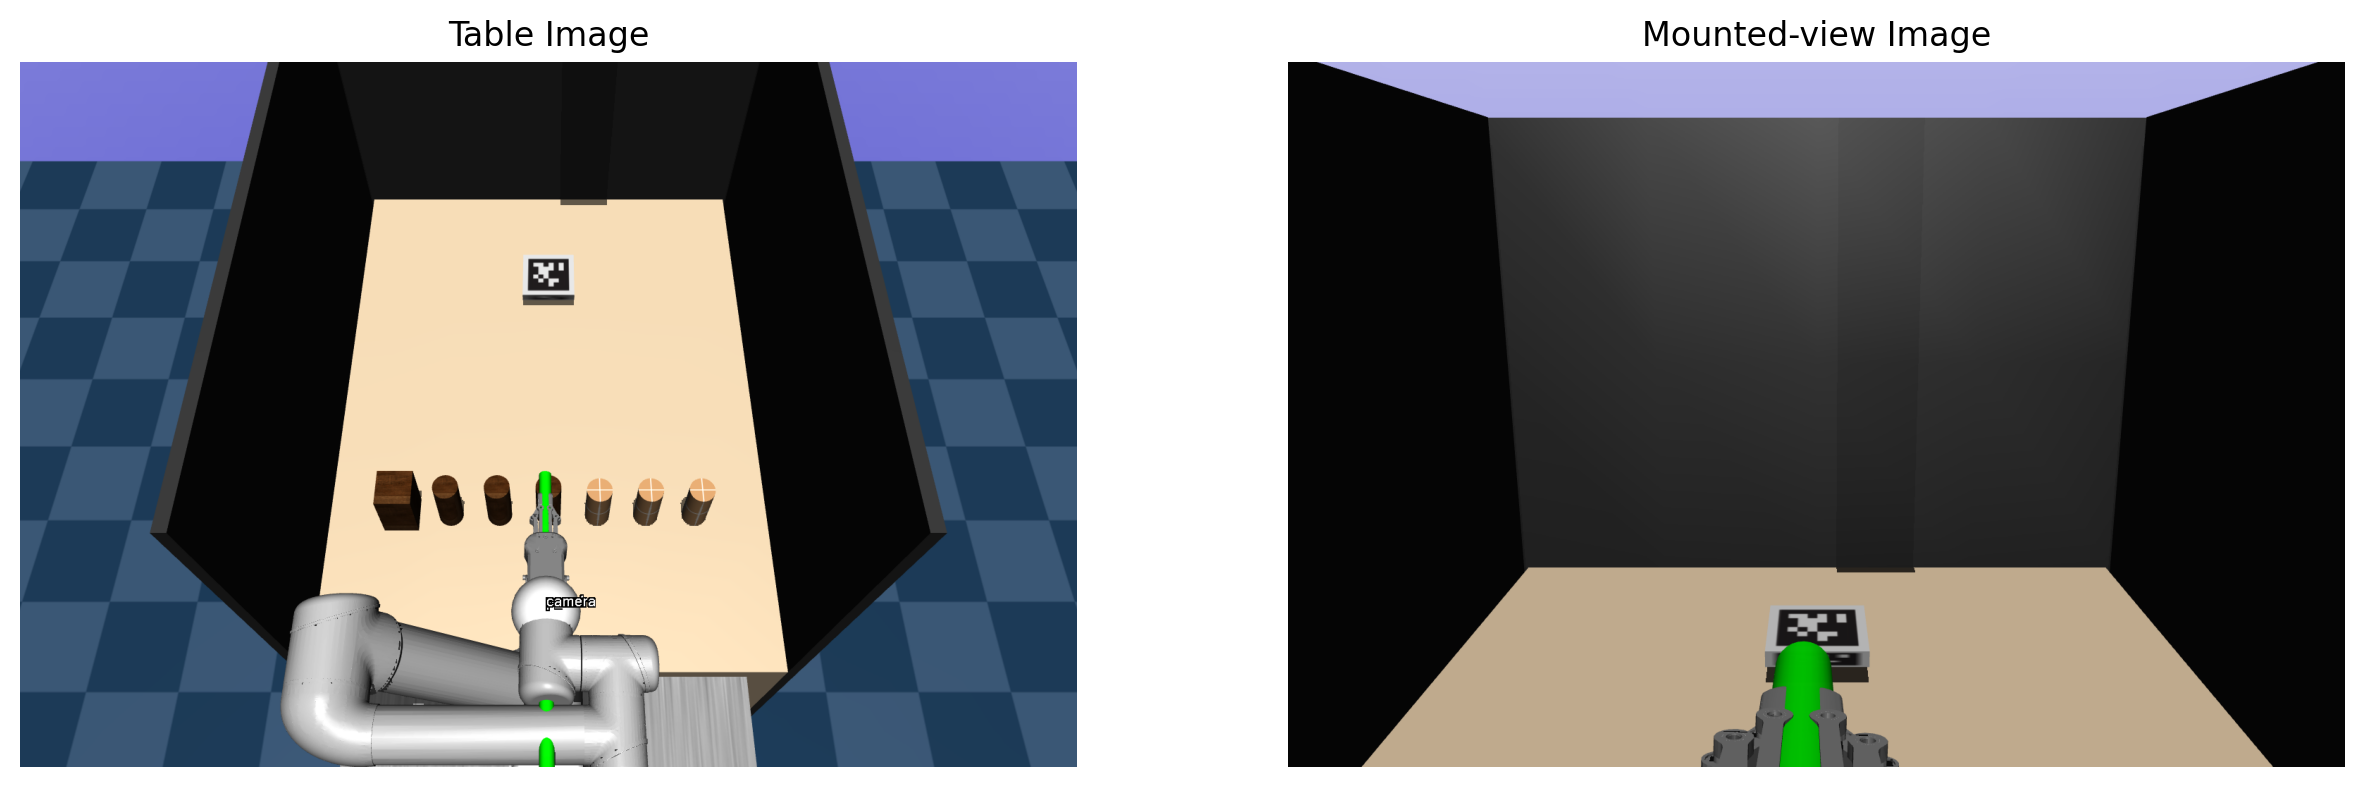

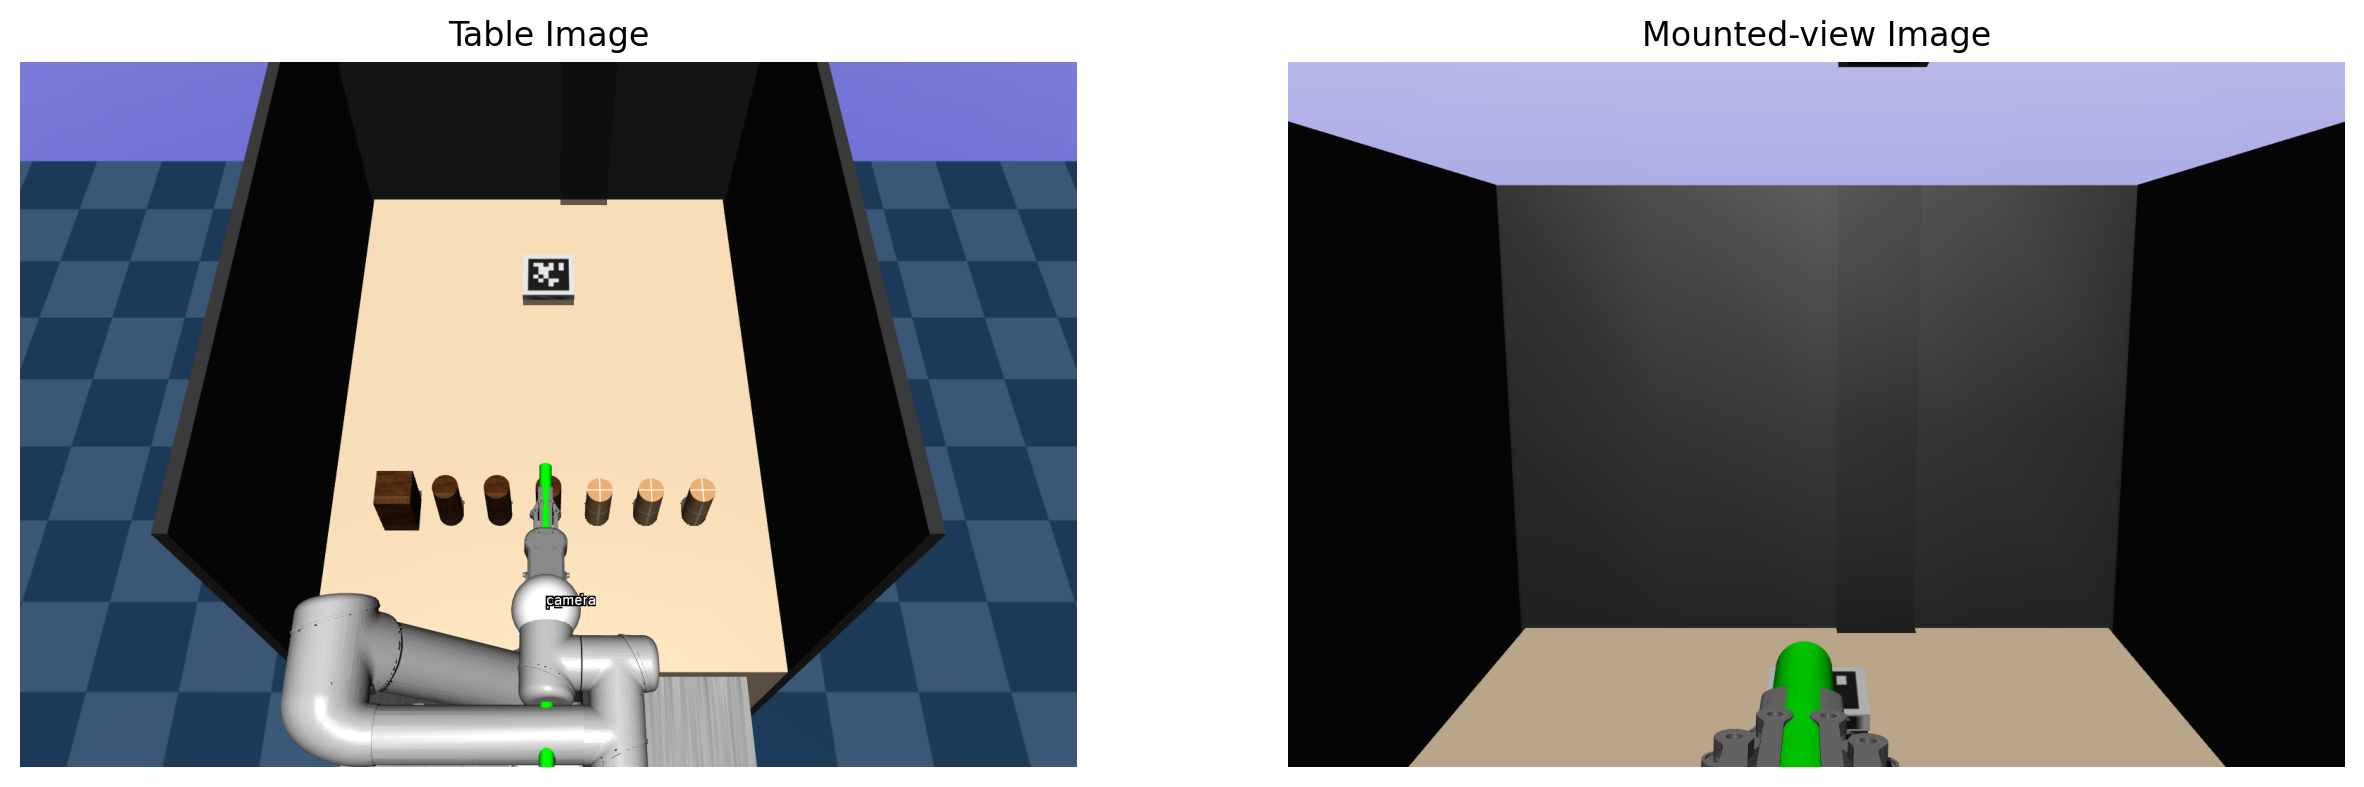

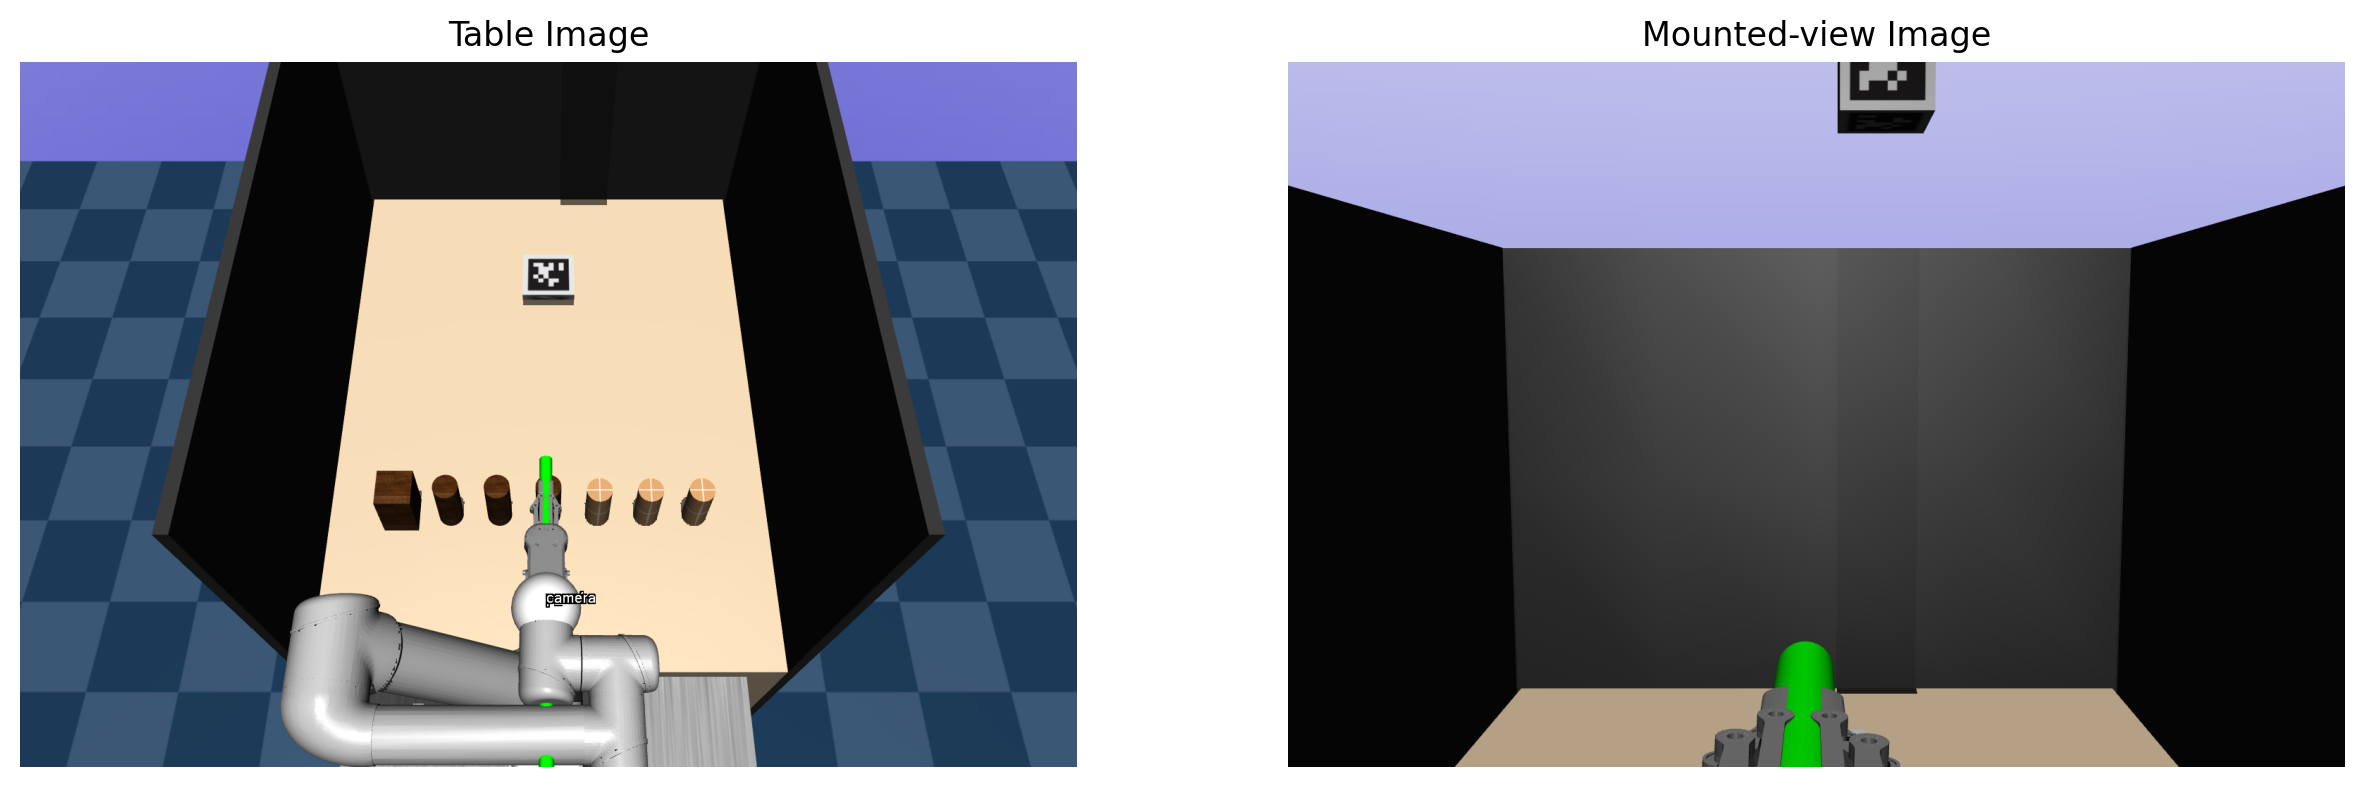

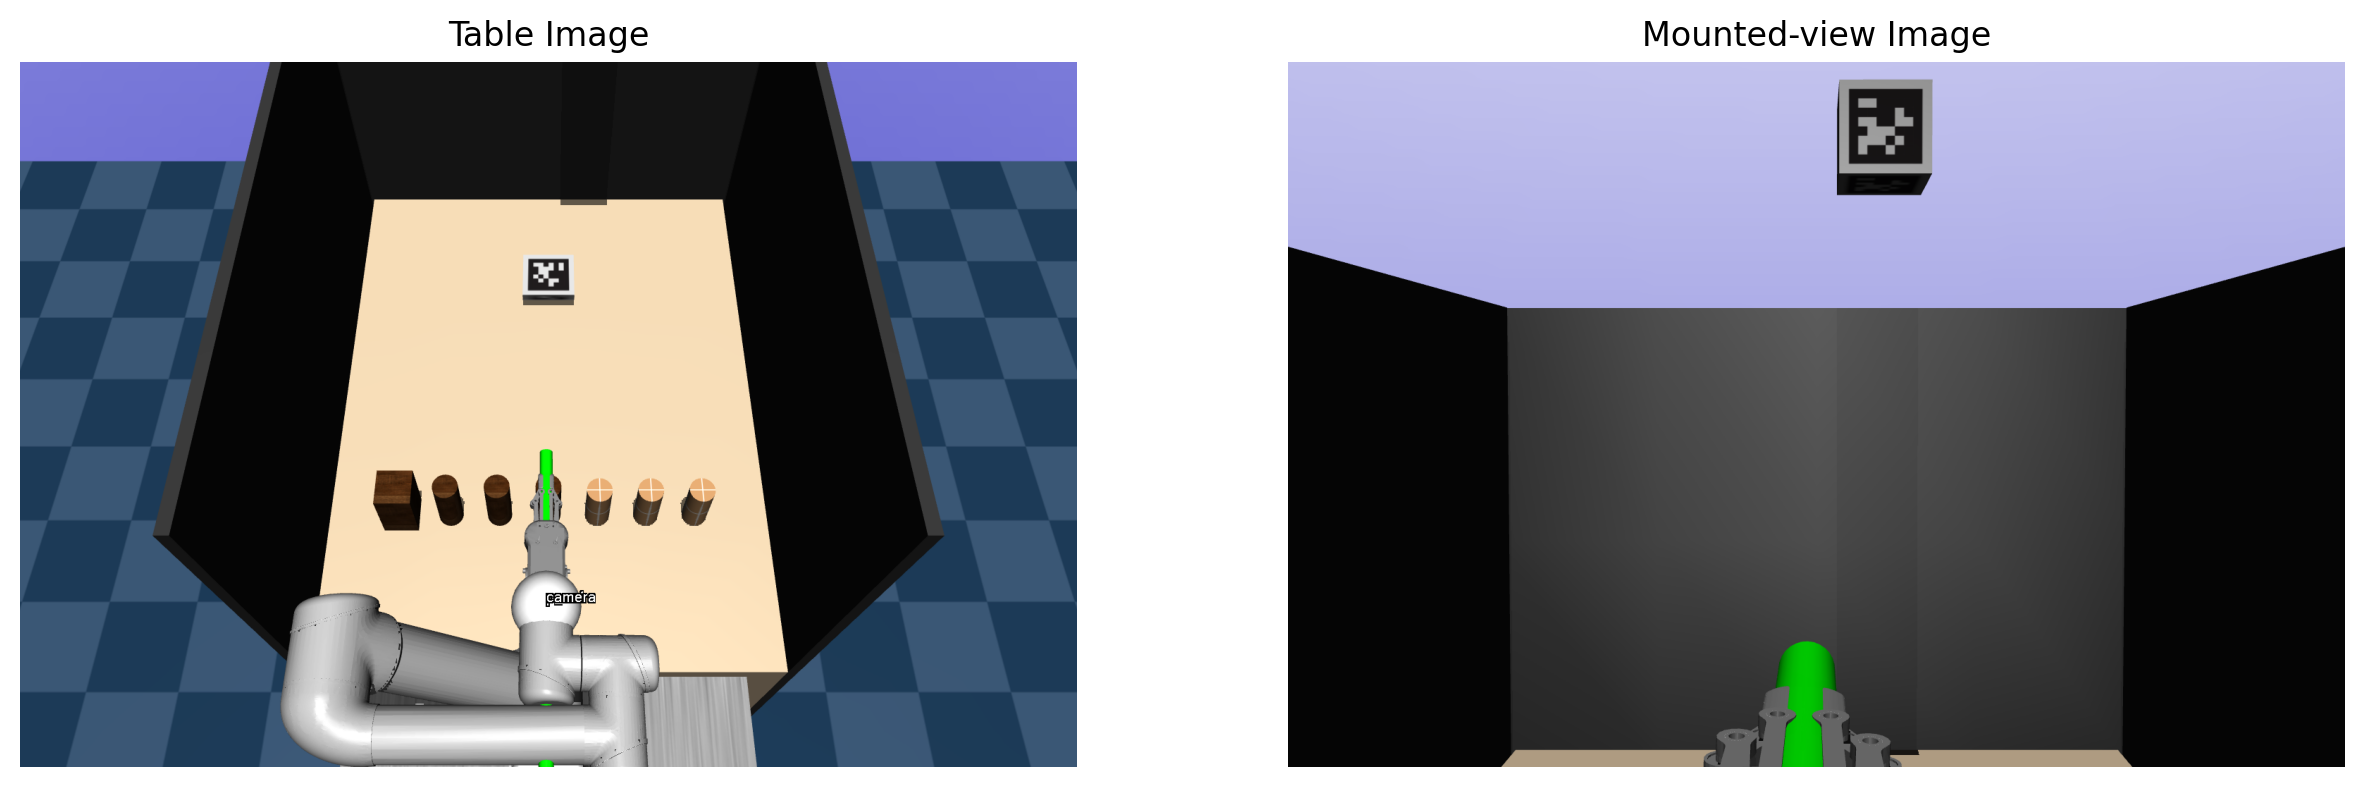

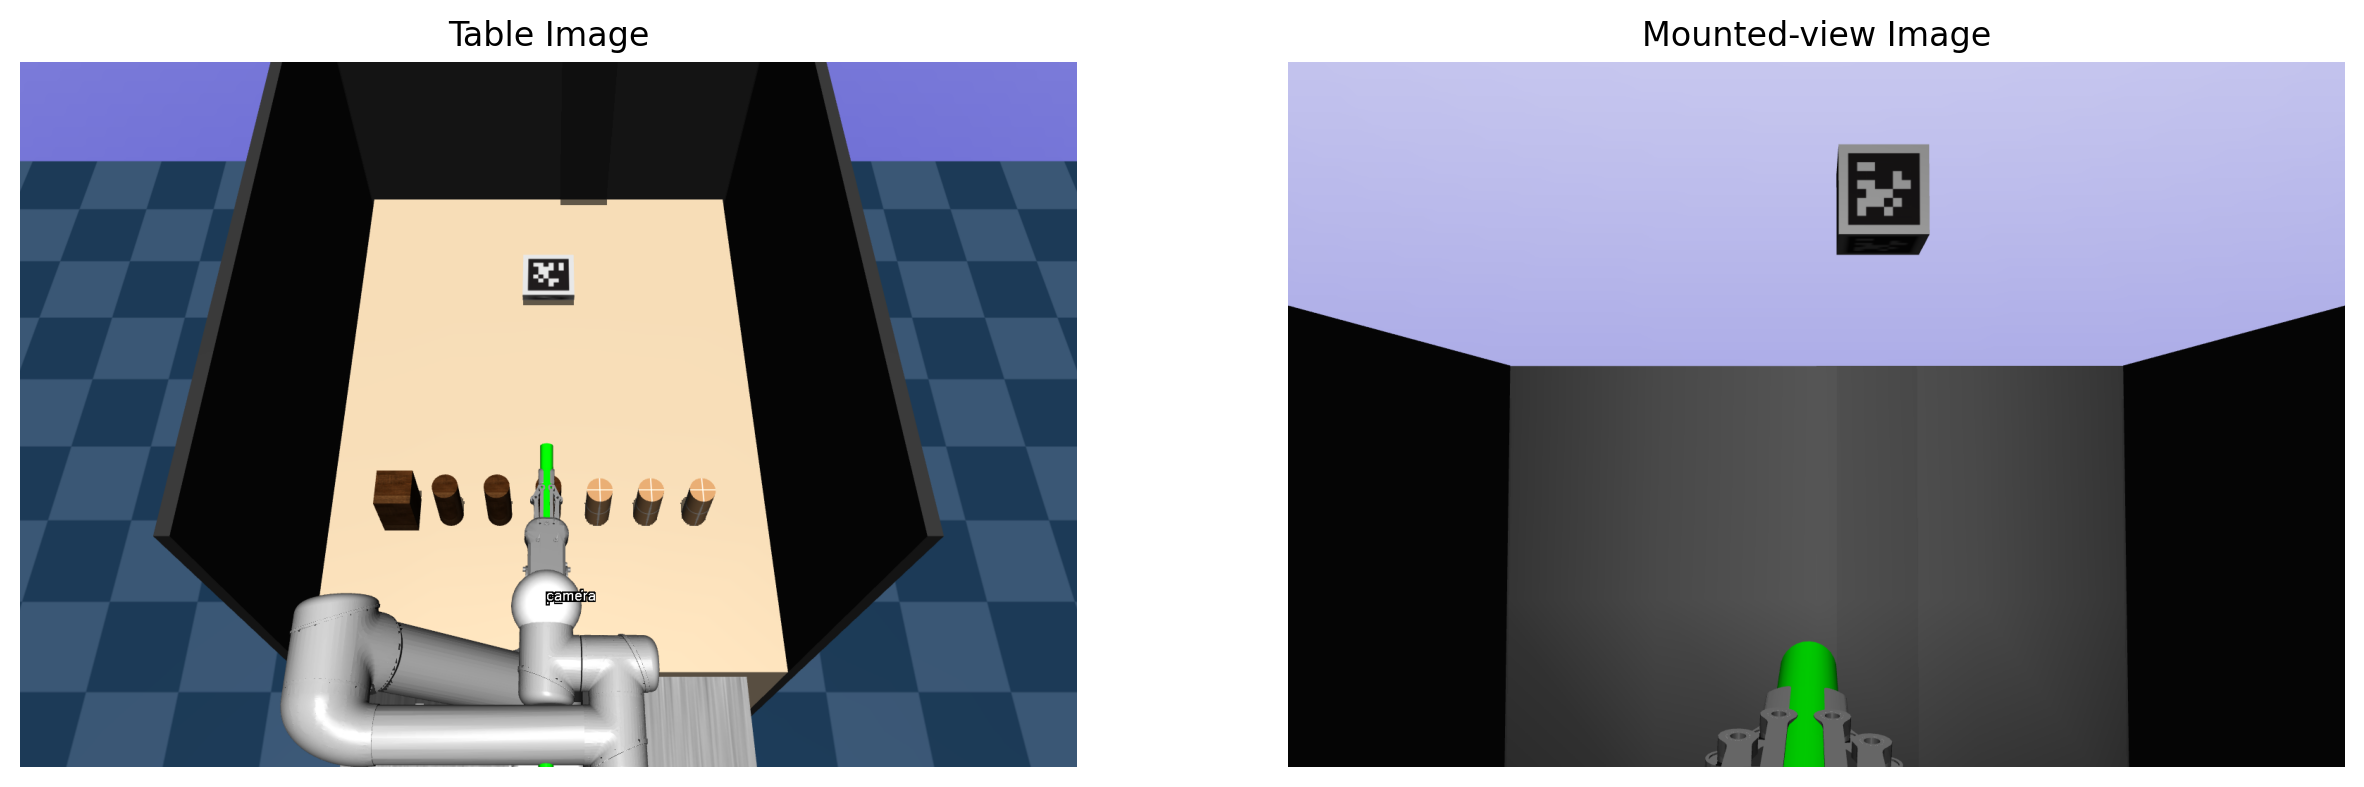

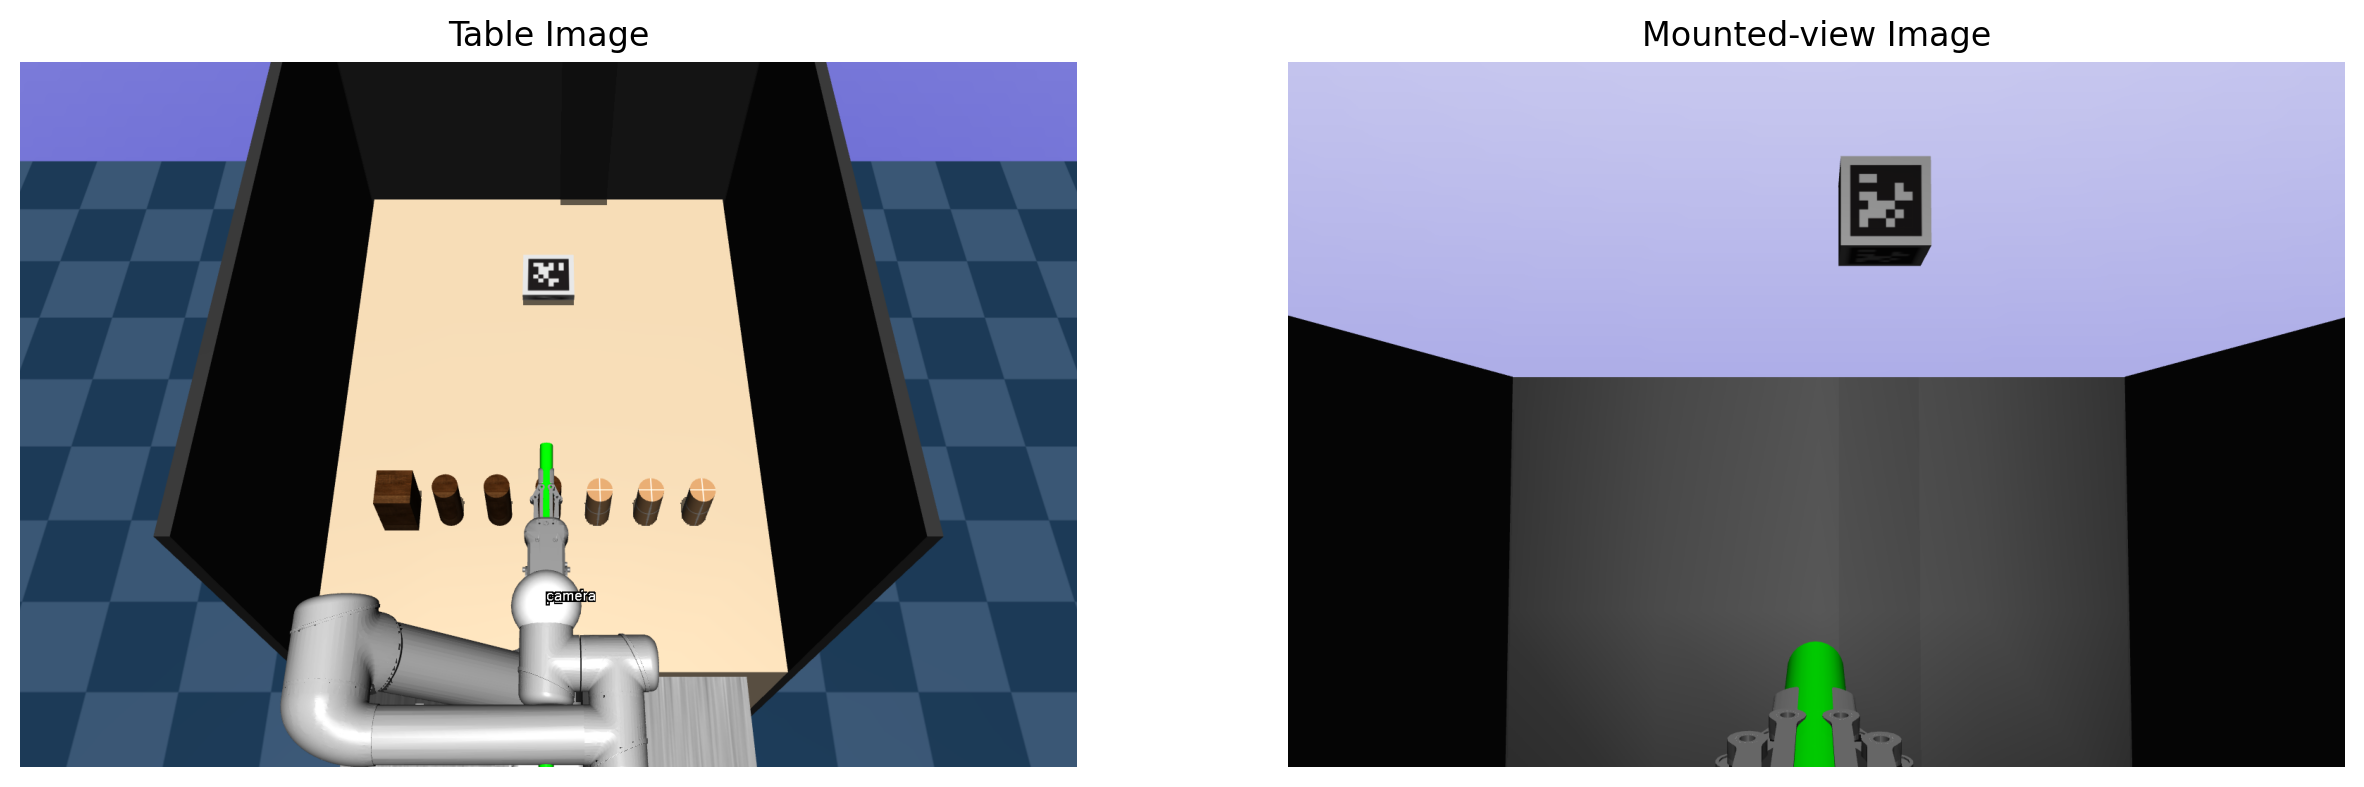

In [14]:
import math

rpy_list = []
r_list = []
eef_list = []

# delete all the markers.
del env.viewer._markers[:]

# Check available objects whose names start with 'obj_'
# Set objects behind of apriltag
obj_names = get_env_obj_names(env,prefix='obj_') # see objects

for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [0.7,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=None)

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

max_tick = 10
env.tick = 0

while env.tick < max_tick:
    # Set Joint Configurations
    init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/6-0.02*env.tick*math.pi, -math.pi/2 ]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # update object, robot configurations
    env.step()
    env.forward(INCREASE_TICK=False)

    # Get pose what I want to attach on.
    # Get e.e. pose.
    p_eef = env.get_p_body("ur_rg2_gripper_base_link")
    R_eef = env.get_R_body("ur_rg2_gripper_base_link")
    
    # p_eef = env.get_p_body("ur_rg2_gripper_base_link")
    # R_eef = env.get_R_body("ur_rg2_gripper_base_link")
    R_y = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,1,0]))
    R_z = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))

    axis_len = 0.18

    p_y = p_eef - R_y[:,2]*axis_len/2
    p_z = p_eef + R_z[:,2]*axis_len/2
    # print(f"the p_z is : {p_z}")
    # print(f"the eef is : {p_eef}")

    env.viewer.add_marker(
        pos   = p_eef,
        type  = mujoco_py.generated.const.GEOM_CYLINDER,
        size  = [0.01,0.01,0.5/2],
        mat   = R_z,
        rgba  = [0.0,1.0,0.0,0.9],
        label = 'p_eef'
    )

    env.add_marker_sphere(p=p_eef,radius=0.05,rgba=[1.0,1.0,1.0,1.0],label='camera')

    # Arbitrary offset on camera btw arm.
    # arbi_offset = [0.05, 0, 0.05]
    arbi_offset = [0.0, 0, 0]

    # View Up-right the table.
    cam_table = env.set_cam_infos(cam_distance  = 1.0,
                        cam_azimuth   = 0,   # Z-axis: Yaw
                        cam_elevation = -60,      # X-axis: Roll                        
                        cam_lookat    = [0.5, 0, 1.5])  # arbitrary offset on camera.

    for _ in range(5):
        img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(img_table); plt.axis('off')
    plt.title("Table Image")
    
    R_eef_rpy = r2rpy(R_eef, unit='deg')

    # Follow Robot E.E.
    # cam_infos = env.set_cam_infos(cam_distance  = 0.1,
    #                     cam_azimuth   = R_z_rpy[2]-90,      # Z-axis: Yaw
    #                     cam_elevation = R_z_rpy[1],         # X-axis: Roll                        
    #                     cam_lookat    = p_eef+arbi_offset)  # arbitrary offset on camera.
    # Follow Robot E.E.
    cam_infos = env.set_cam_infos(cam_distance  = 0.05,
                        cam_azimuth   = R_eef_rpy[2]+90,      # Z-axis: Yaw
                        cam_elevation = R_eef_rpy[0]+90,         # X-axis: Roll                        
                        cam_lookat    = p_y)  # arbitrary offset on camera.

    # update object, robot configurations
    env.forward(INCREASE_TICK=False)

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth2meters(img_depth))

    plt.subplot(1,2,2)
    plt.imshow(img); plt.axis('off')
    plt.title("Mounted-view Image")
    plt.show()

    # delete all the markers.
    del env.viewer._markers[:]


In [ ]:
eef_list

[array([0.36, 0.  , 1.14]),
 array([0.36, 0.  , 1.14]),
 array([0.36, 0.  , 1.15]),
 array([0.36, 0.  , 1.15]),
 array([0.37, 0.  , 1.16]),
 array([0.37, 0.  , 1.16]),
 array([0.37, 0.  , 1.17]),
 array([0.37, 0.  , 1.17]),
 array([0.37, 0.  , 1.18]),
 array([0.37, 0.  , 1.18])]

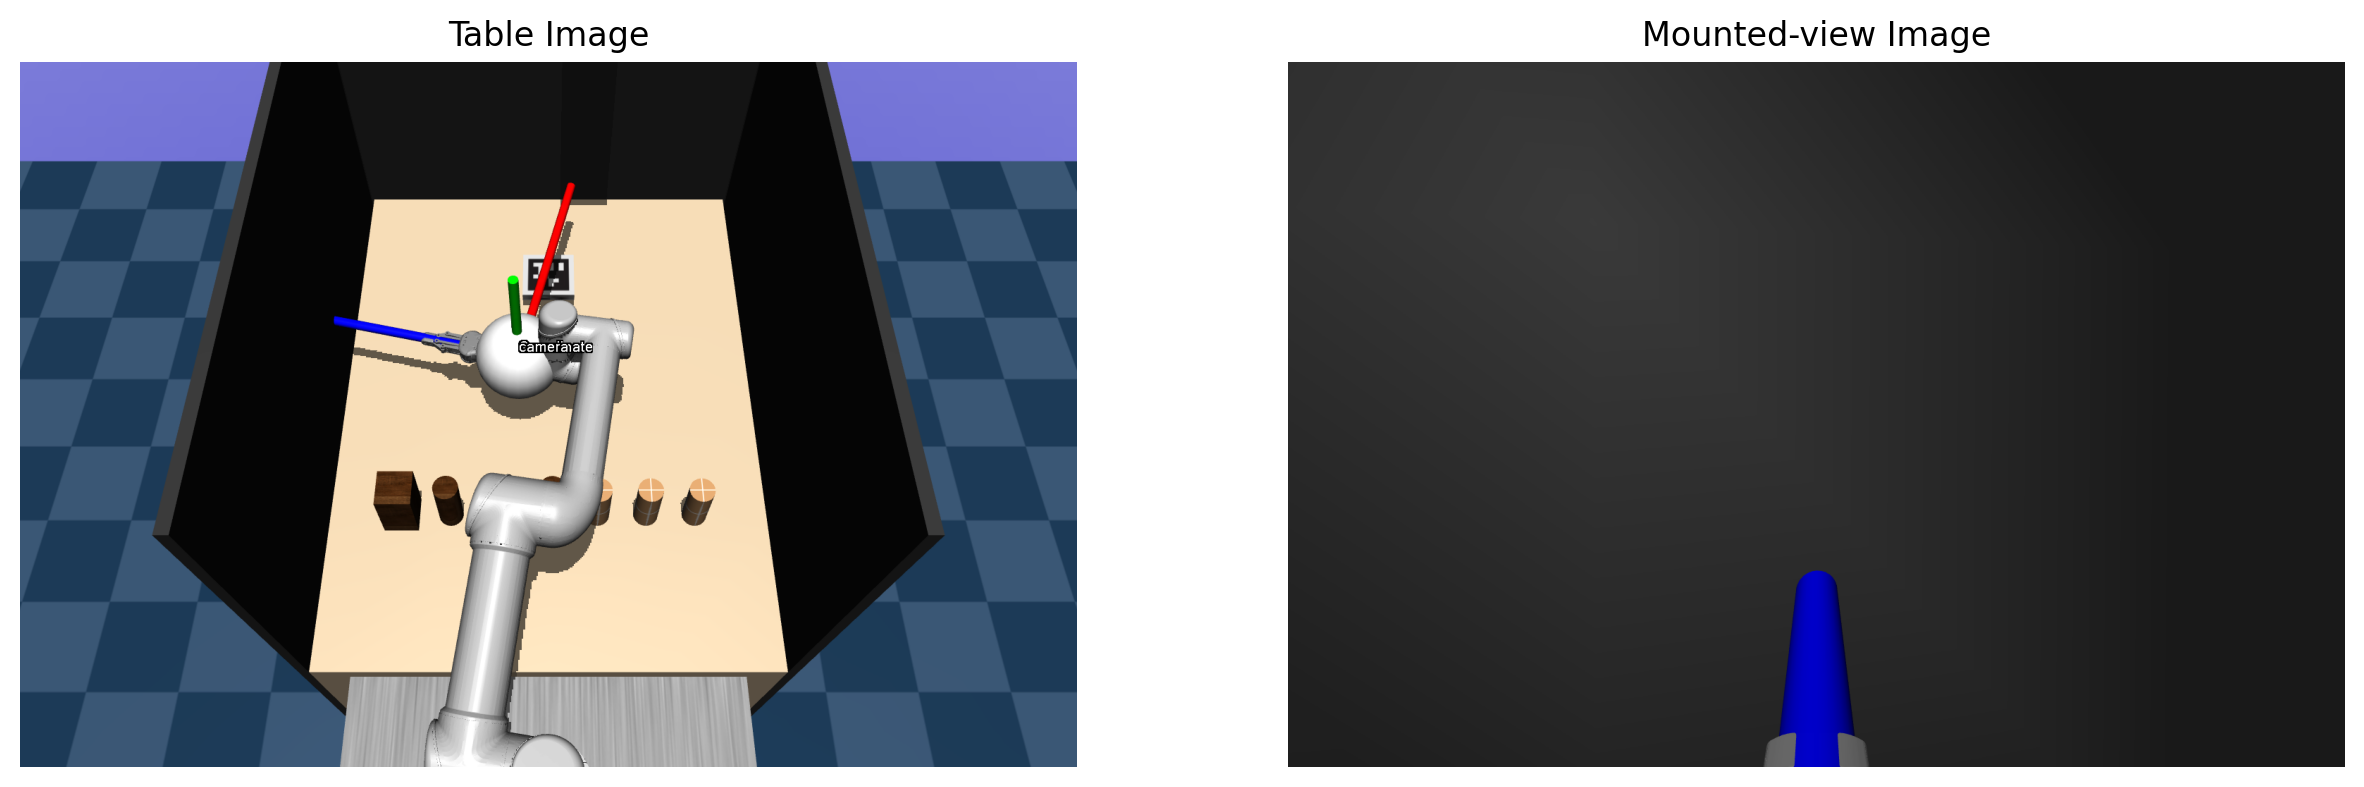

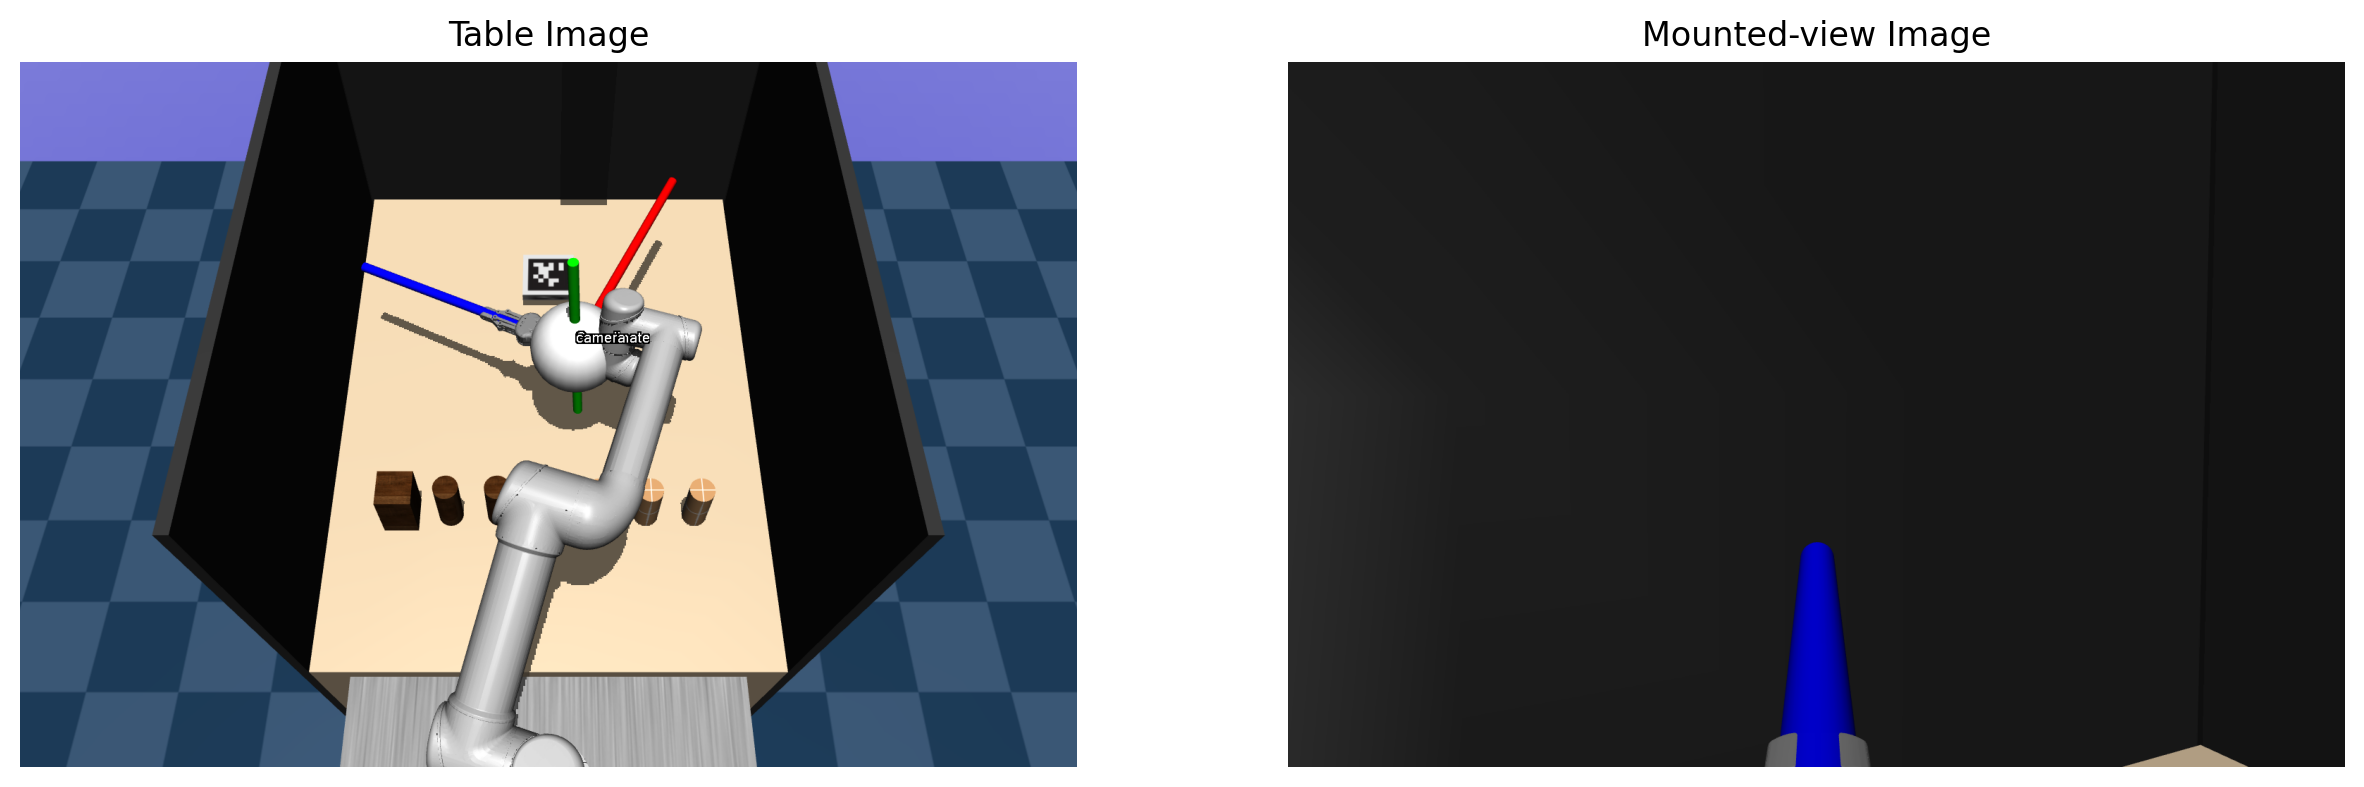

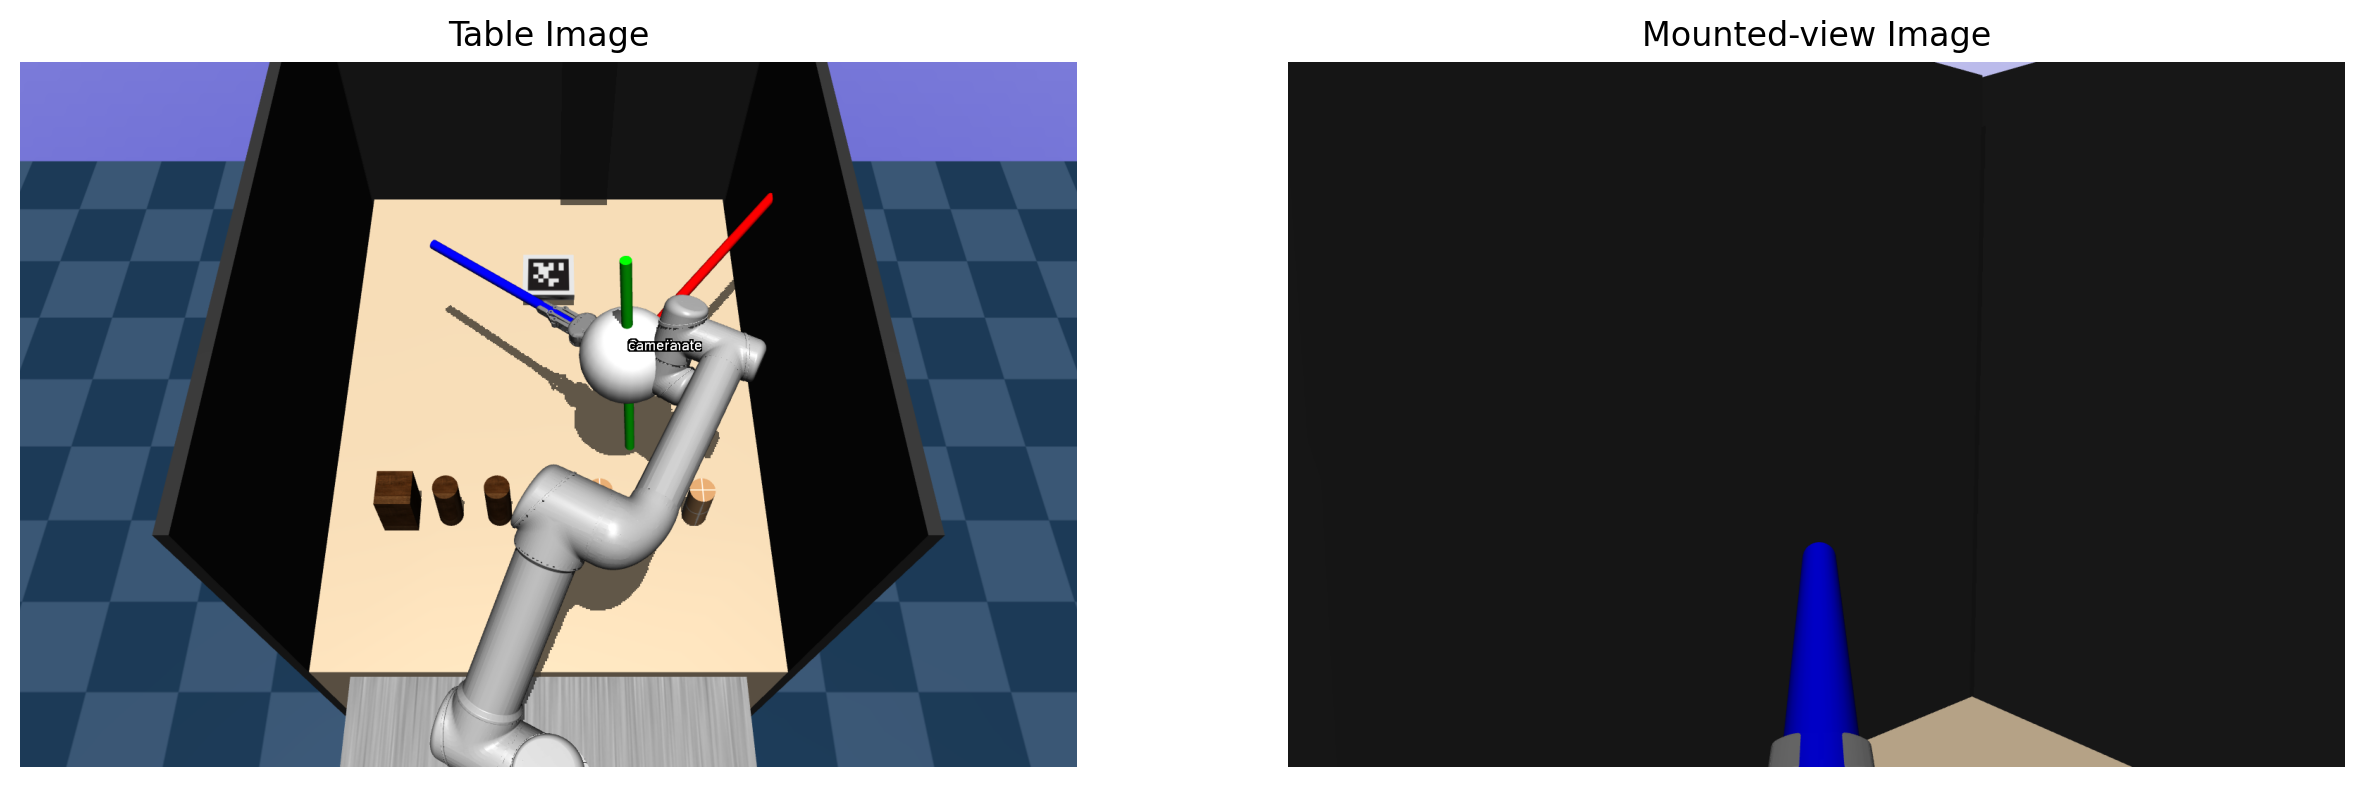

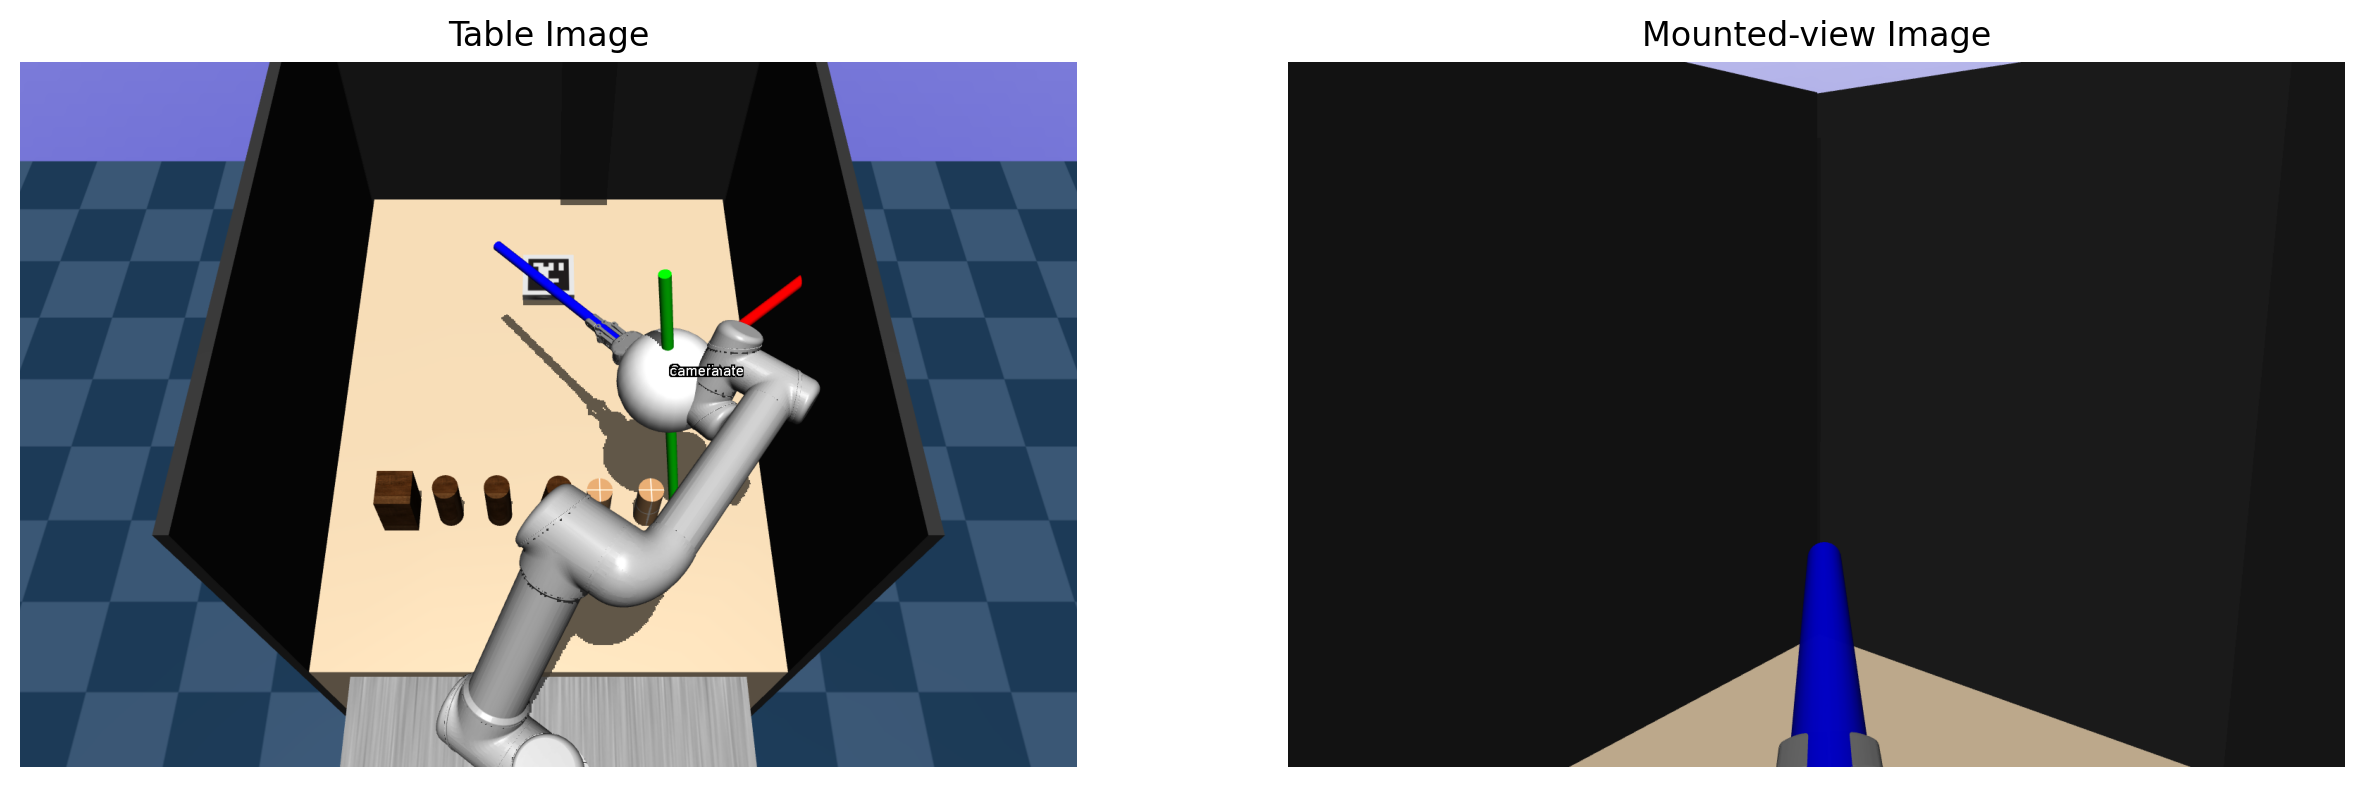

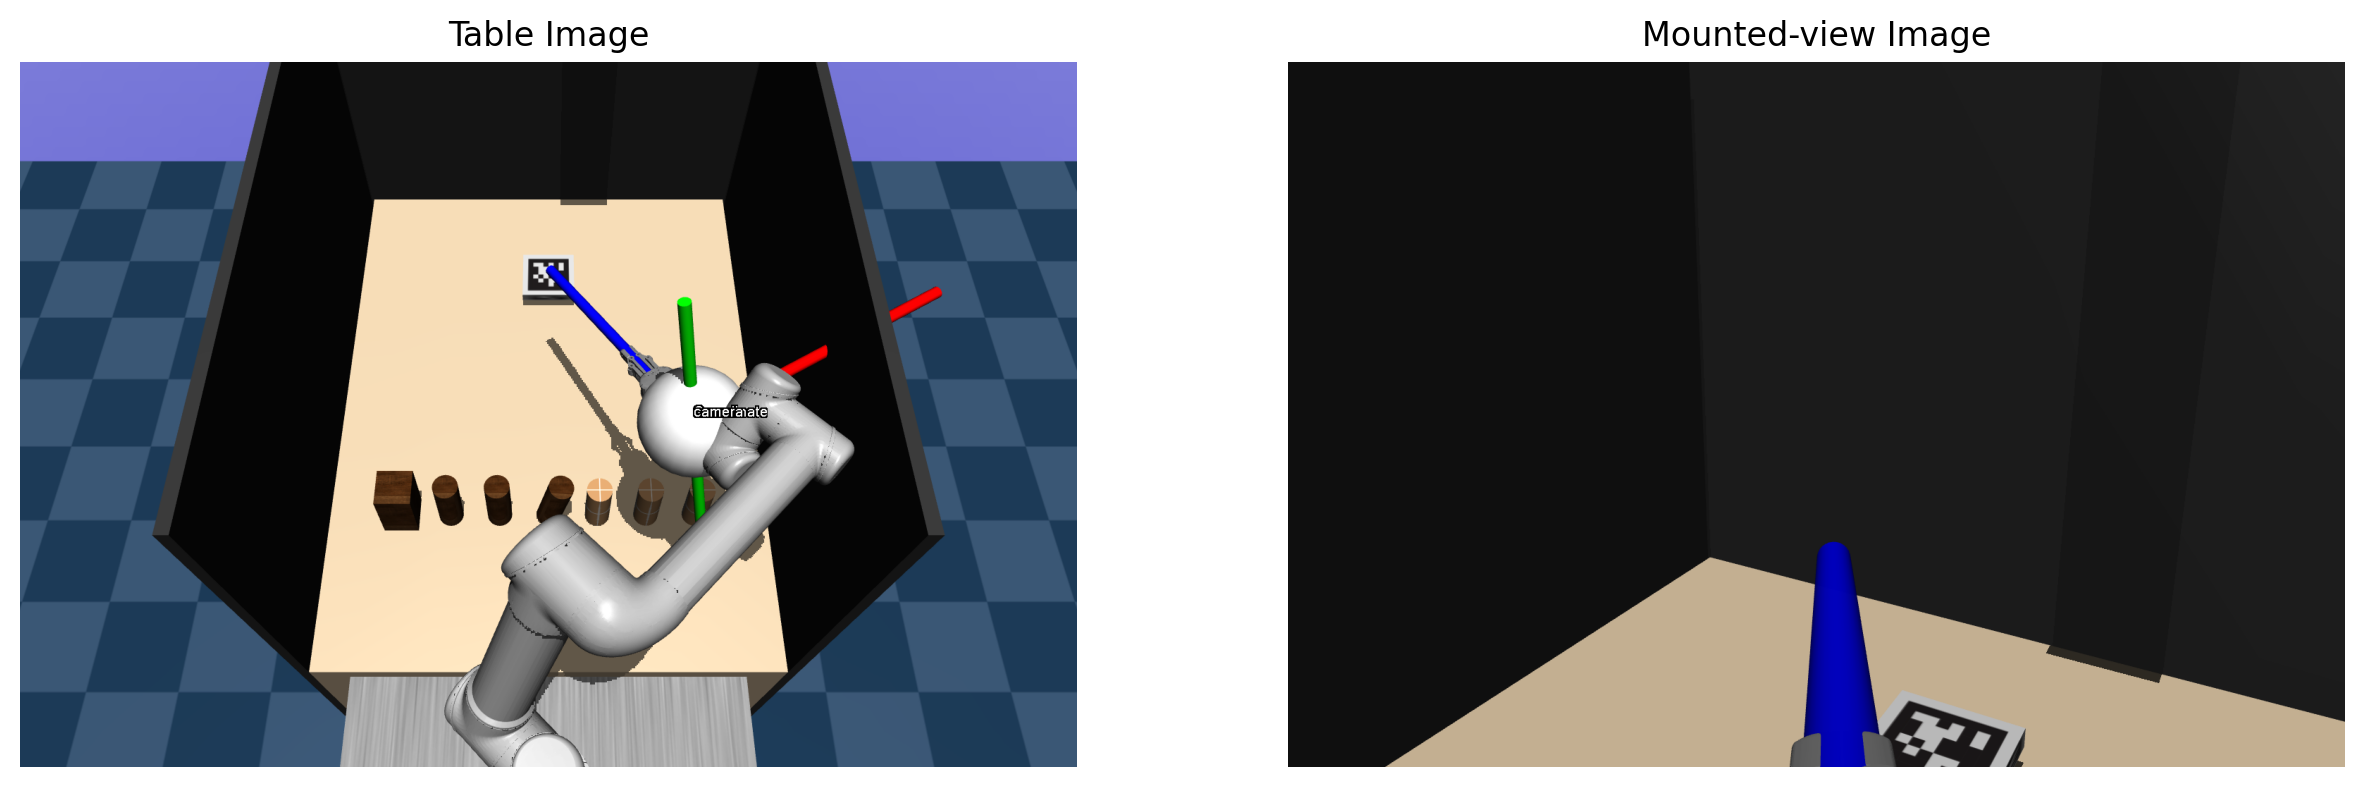

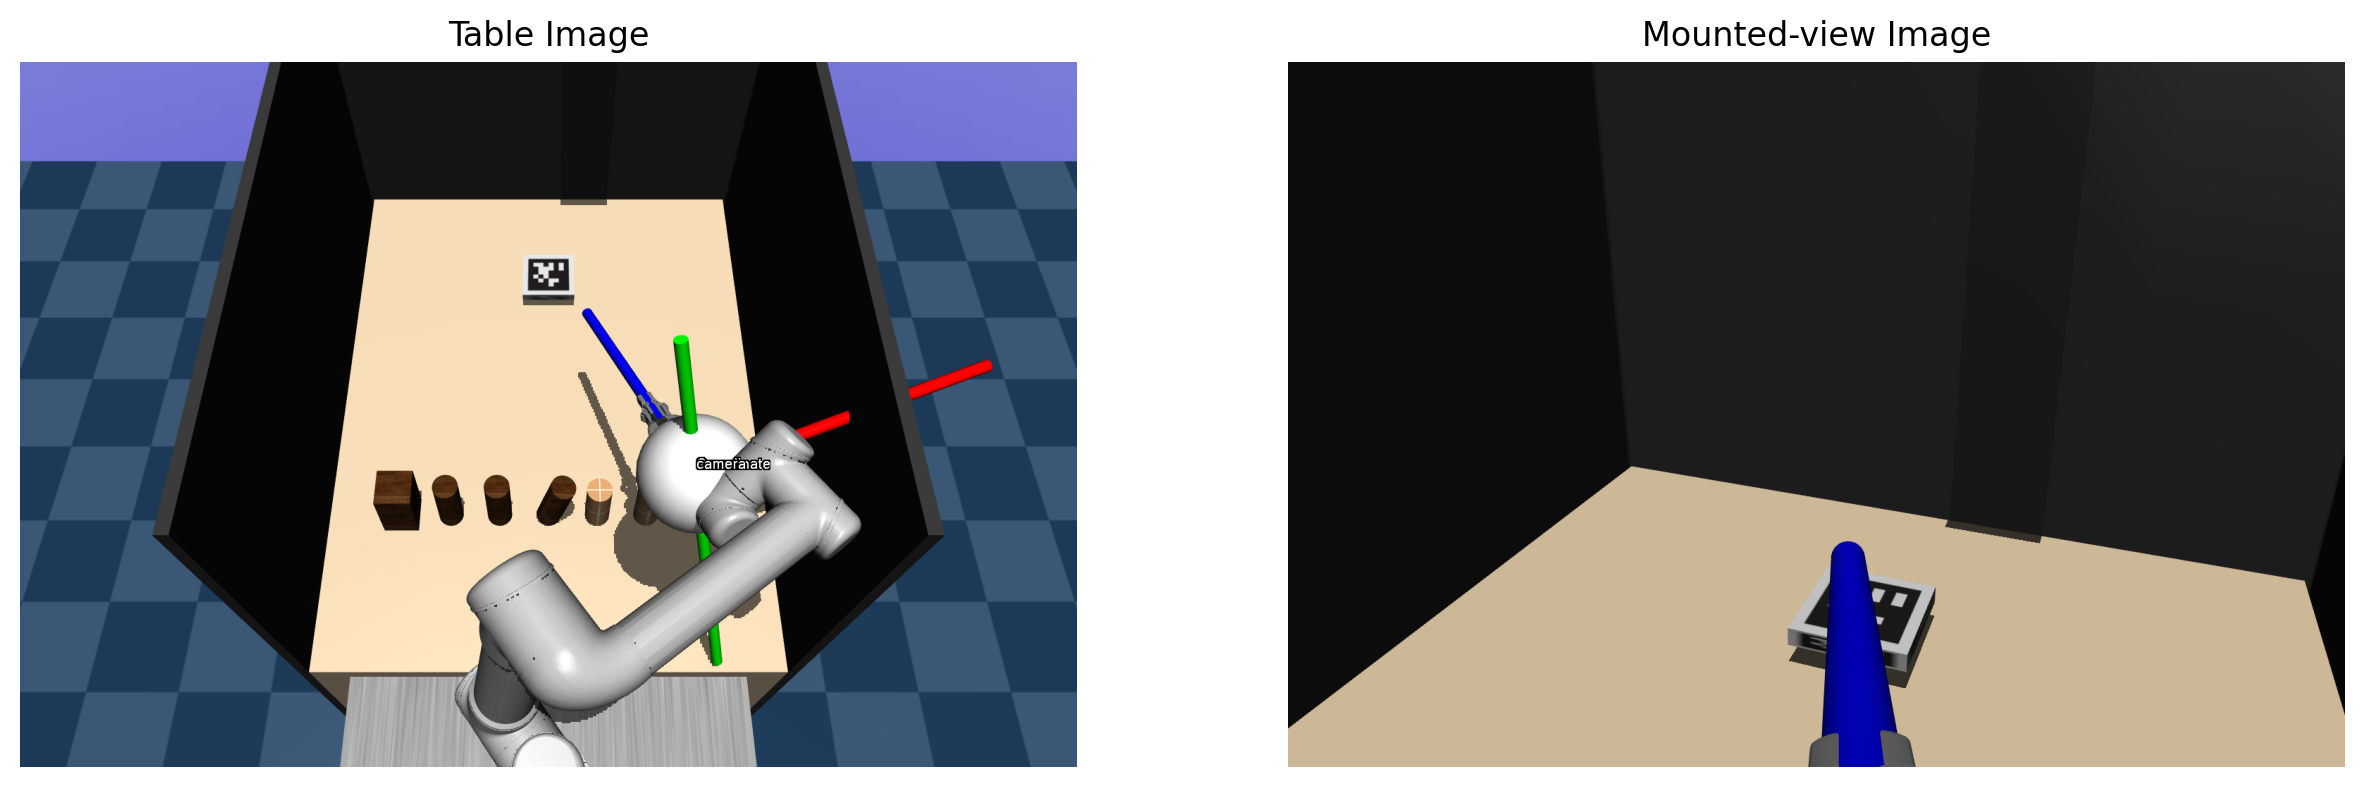

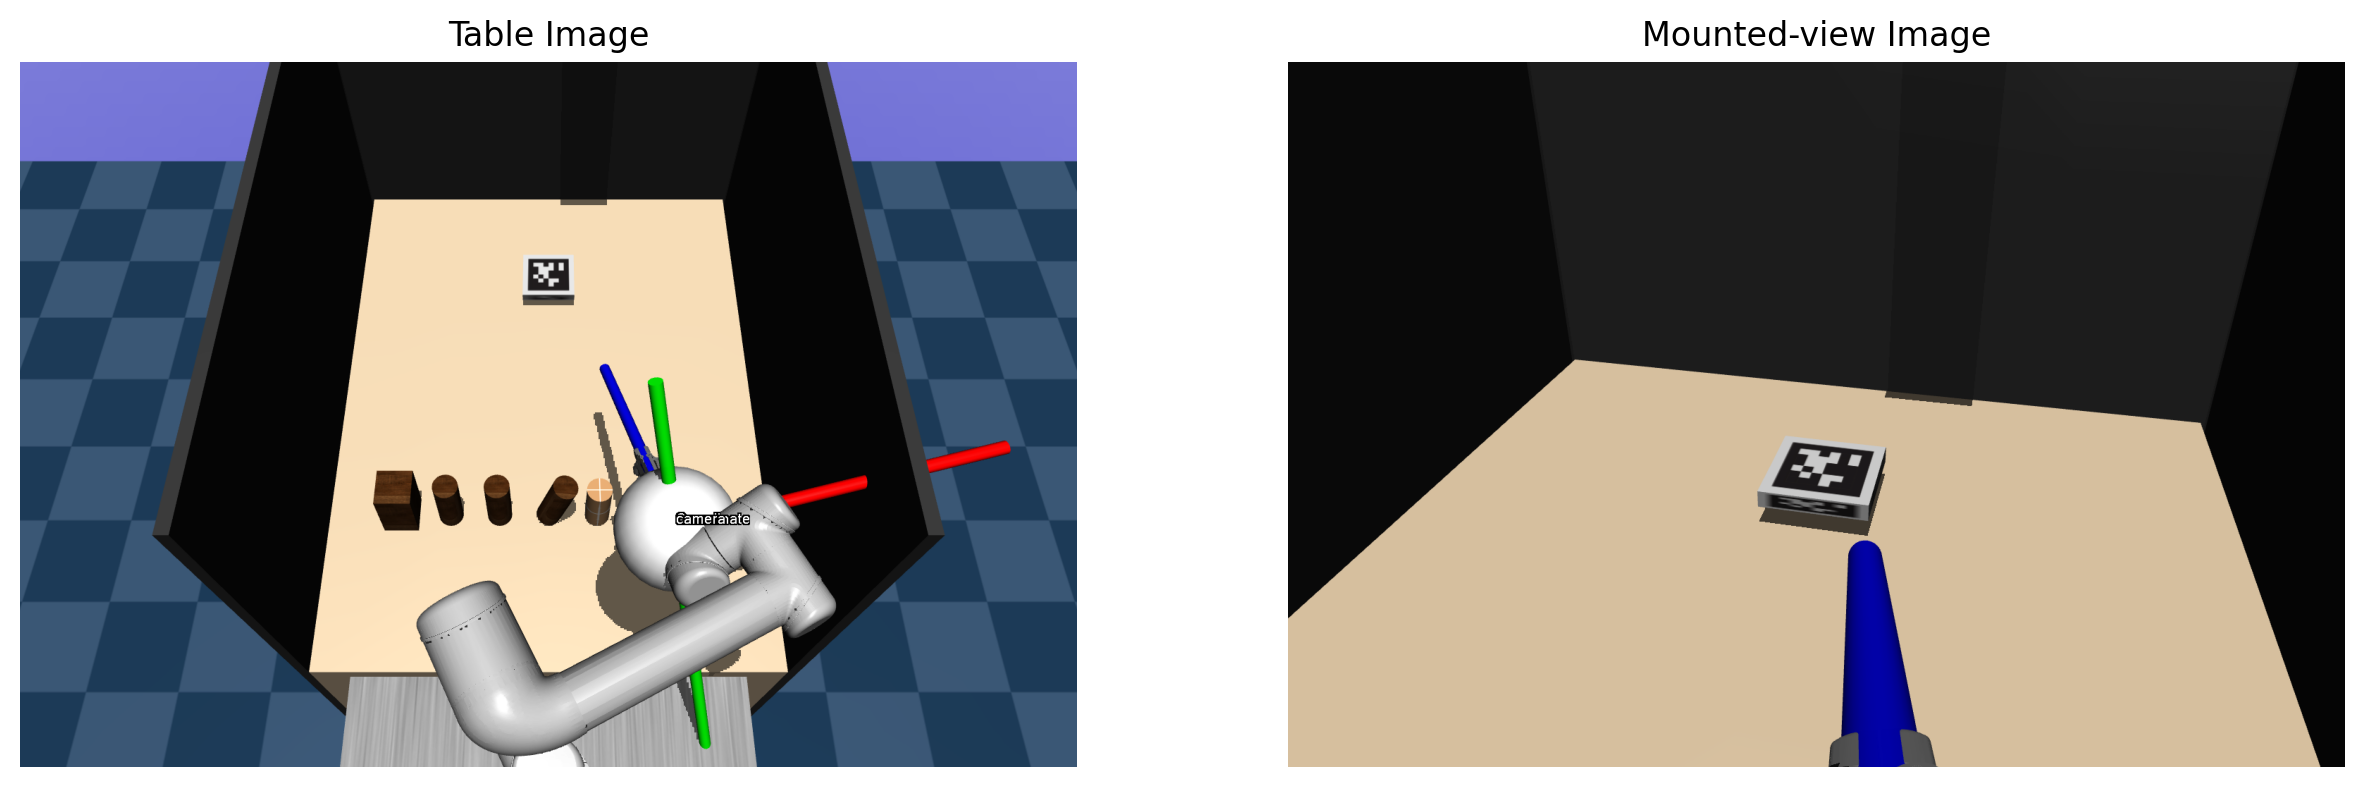

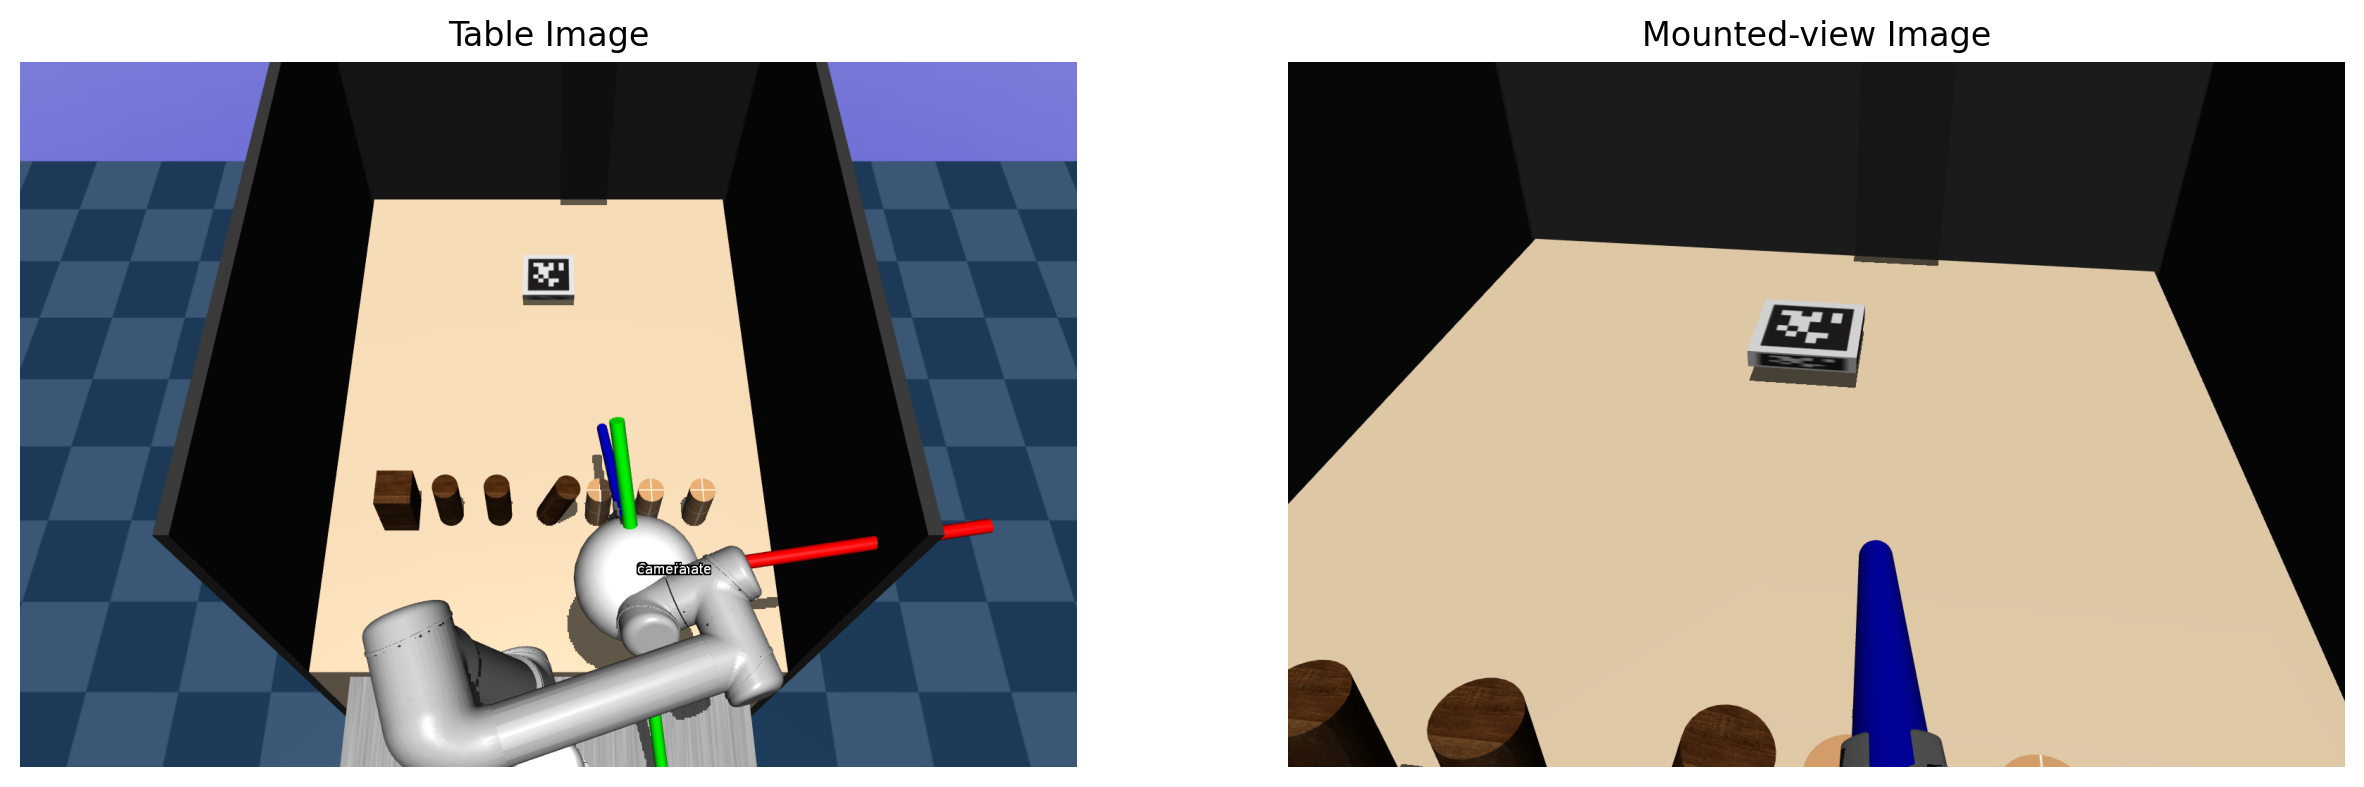

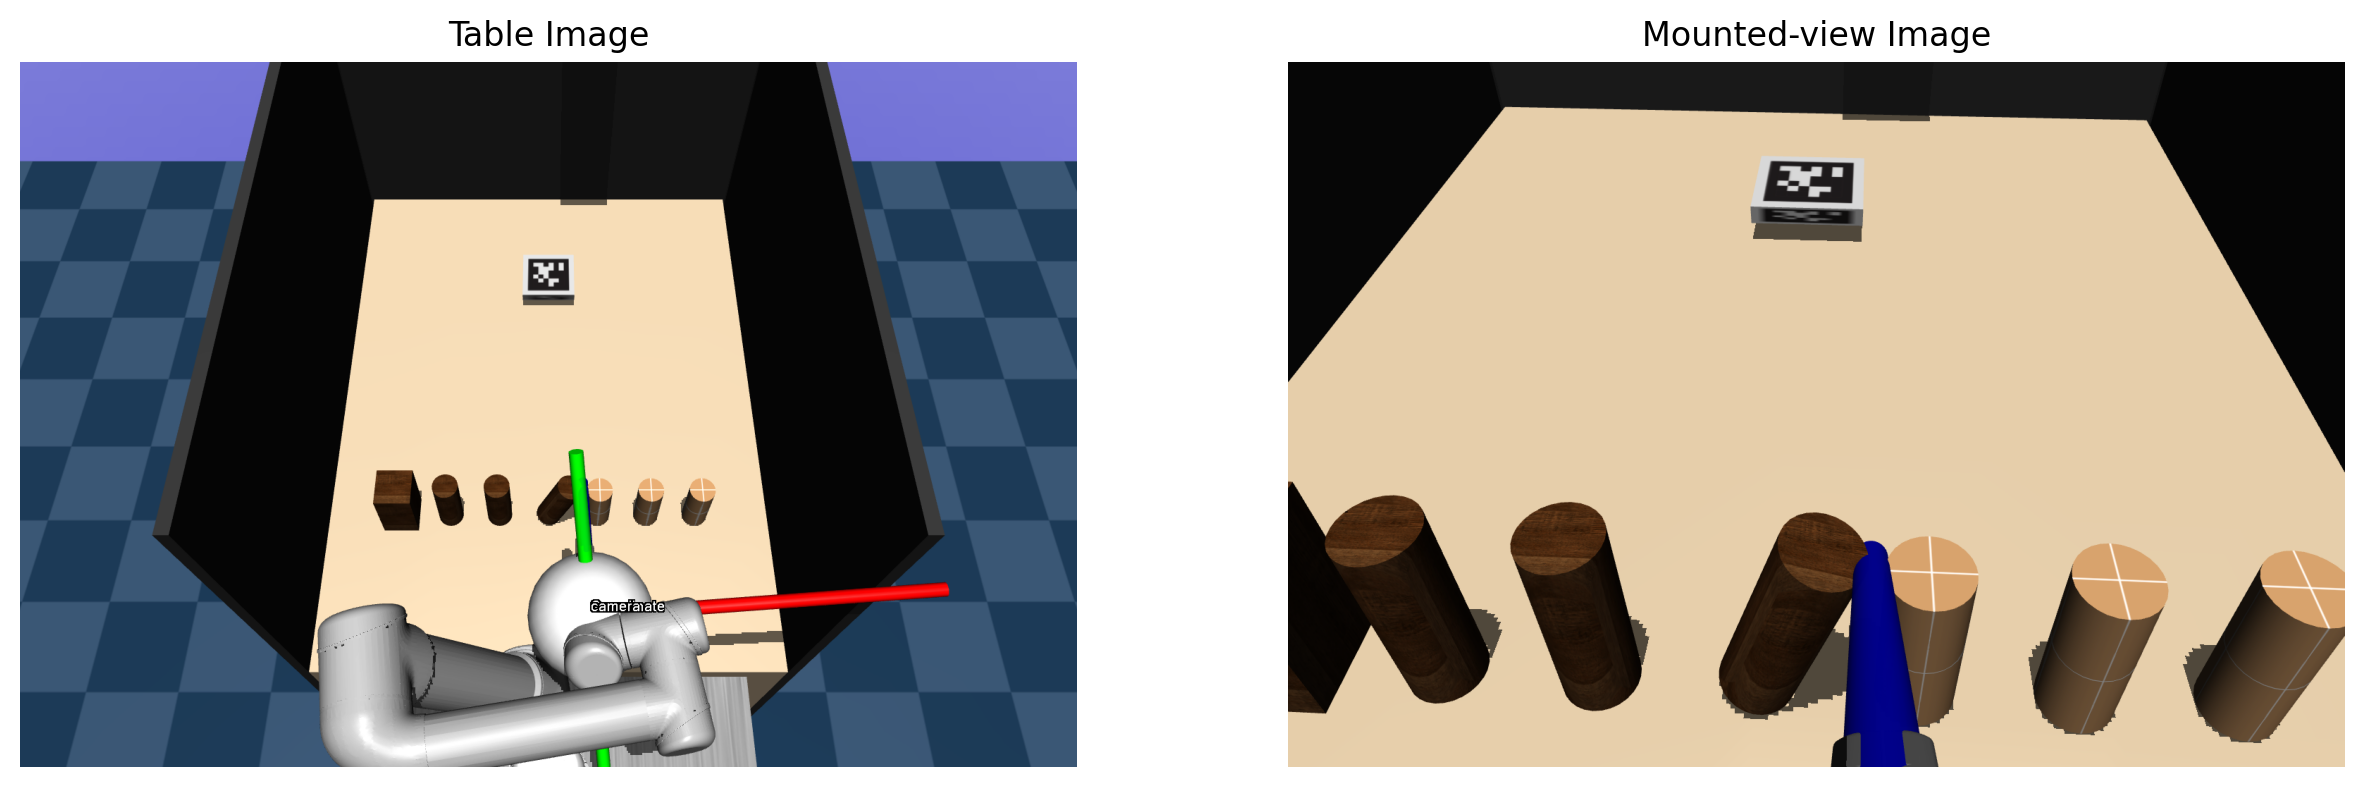

In [98]:
import math

# delete all the markers.
del env.viewer._markers[:]

# Check available objects whose names start with 'obj_'
# Set objects behind of apriltag
obj_names = get_env_obj_names(env,prefix='obj_') # see objects

for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [0.7,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=None)

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

max_tick = 10
env.tick = 0

init_configurations = [0, 0, 0, 0, 0, 0]
set_env_joint_configuration(env, init_configurations, prefix='ur_')

# Extrinsic calbration list
tagpose_list = []
bs2ee_list = []

# update object, robot configurations
env.step()

while env.tick < max_tick:
    # Set Joint Configurations
    init_configurations = [-math.pi/2*0.1*env.tick, -3*math.pi/4*0.1*env.tick, 3*math.pi/4*0.1*env.tick, math.pi/2*0.1*env.tick, math.pi/4*0.1*env.tick, -math.pi/2*0.1*env.tick ]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # update object, robot configurations
    env.step()
    env.forward(INCREASE_TICK=False)
    
    env.sim_state = env.sim.get_state()
    p_eef = np.array(env.sim.data.body_xpos[env.body_name2idx("ur_rg2_gripper_base_link")])    

    # Get pose what I want to attach on.
    # Get wrist pose.
    # p_eef = env.get_p_body("ur_rg2_gripper_base_link")
    R_eef = env.get_R_body("ur_rg2_gripper_base_link")

    R_y = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,1,0]))
    axis_len = 0.17
    p_y = p_eef - R_y[:,2]*axis_len/2

    R_z = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))
    R_coord    = R_eef # rpy2r(np.deg2rad([0,0,0]))
    env.add_marker_coordinate(
        p=p_eef,R=R_coord,axis_len=0.5,axis_width=0.01,label='Coordinate')

    env.add_marker_sphere(p=p_eef,radius=0.09,rgba=[1.0,1.0,1.0,1.0],label='camera')

    env.viewer.add_marker(
        pos   = p_eef,
        type  = mujoco_py.generated.const.GEOM_CYLINDER,
        size  = [0.01,0.01,0.5/2],
        mat   = R_y,
        rgba  = [0.0,1.0,0.0,0.9],
        label = ''
    )

    R_z_rpy = np.degrees(r2rpy(R_z))
    
    # Arbitrary offset on camera btw arm.
    # arbi_offset = [0.05, 0, 0.10]
    arbi_offset = [0.0, 0.0, 0.0]

    # View Up-right the table.
    cam_table = env.set_cam_infos(cam_distance  = 1.0,
                        cam_azimuth   = 0,   # Z-axis: Yaw
                        cam_elevation = -60,      # X-axis: Roll                        
                        cam_lookat    = [0.5, 0, 1.5])  # arbitrary offset on camera.

    for _ in range(5):
        img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(img_table); plt.axis('off')
    plt.title("Table Image")

    # Follow Robot wrist #3.
    cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                        cam_azimuth   = R_z_rpy[2]-90,        # Z-axis: Yaw
                        cam_elevation = -R_z_rpy[0]+90,      # X-axis: Roll                        
                        cam_lookat    = p_y)  # arbitrary offset on camera.

    # update object, robot configurations
    env.forward(INCREASE_TICK=False)

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth2meters(img_depth))

    plt.subplot(1,2,2)
    plt.imshow(img); plt.axis('off')
    plt.title("Mounted-view Image")
    plt.show()

    T_april = get_apriltag_pose(env, img, img_real)
    bs2ee_matrix = get_homogeneous_matrix(env, from_link='ur_base_link', to_link='ur_rg2_gripper_base_link', verbose=False)
    
    tagpose_list.append(T_april)
    bs2ee_list.append(bs2ee_matrix)

    # delete all the markers.
    del env.viewer._markers[:]


In [104]:
get_extrinsic_calibration_frank(bs2ee_list[6:], tagpose_list[6:])

array([[ 0.67, -0.74, -0.08,  0.6 ],
       [-0.69, -0.59, -0.42,  1.96],
       [ 0.26,  0.33, -0.91,  2.11],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [ ]:
get_extrinsic_calibration_tsai(bs2ee_list, tagpose_list)

In [18]:
tagpose_list

[None,
 None,
 None,
 None,
 None,
 None,
 array([[ 0.98, -0.22, -0.  , -0.21],
        [ 0.11,  0.46,  0.88, -0.03],
        [-0.19, -0.86,  0.48,  3.4 ],
        [ 0.  ,  0.  ,  0.  ,  1.  ]]),
 array([[ 9.93e-01, -1.19e-01, -2.52e-03,  9.43e-01],
        [ 7.13e-02,  5.75e-01,  8.15e-01,  8.30e-02],
        [-9.59e-02, -8.09e-01,  5.80e-01,  9.11e+00],
        [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]]),
 array([[ 9.99e-01, -4.80e-02, -2.51e-03,  9.93e-01],
        [ 3.40e-02,  6.69e-01,  7.43e-01,  2.70e-02],
        [-3.40e-02, -7.42e-01,  6.70e-01,  3.62e+00],
        [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])]

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.11111450195312, homography=array([[ 9.34e-01, -5.00e-01,  5.72e+00],
       [ 4.33e-02,  3.89e-02,  5.91e+00],
       [ 6.92e-05, -6.63e-04,  1.02e-02]]), center=array([558.37, 577.01]), corners=array([[487.68, 537.81],
       [651.84, 538.92],
       [637.77, 621.04],
       [450.52, 620.97]]))]


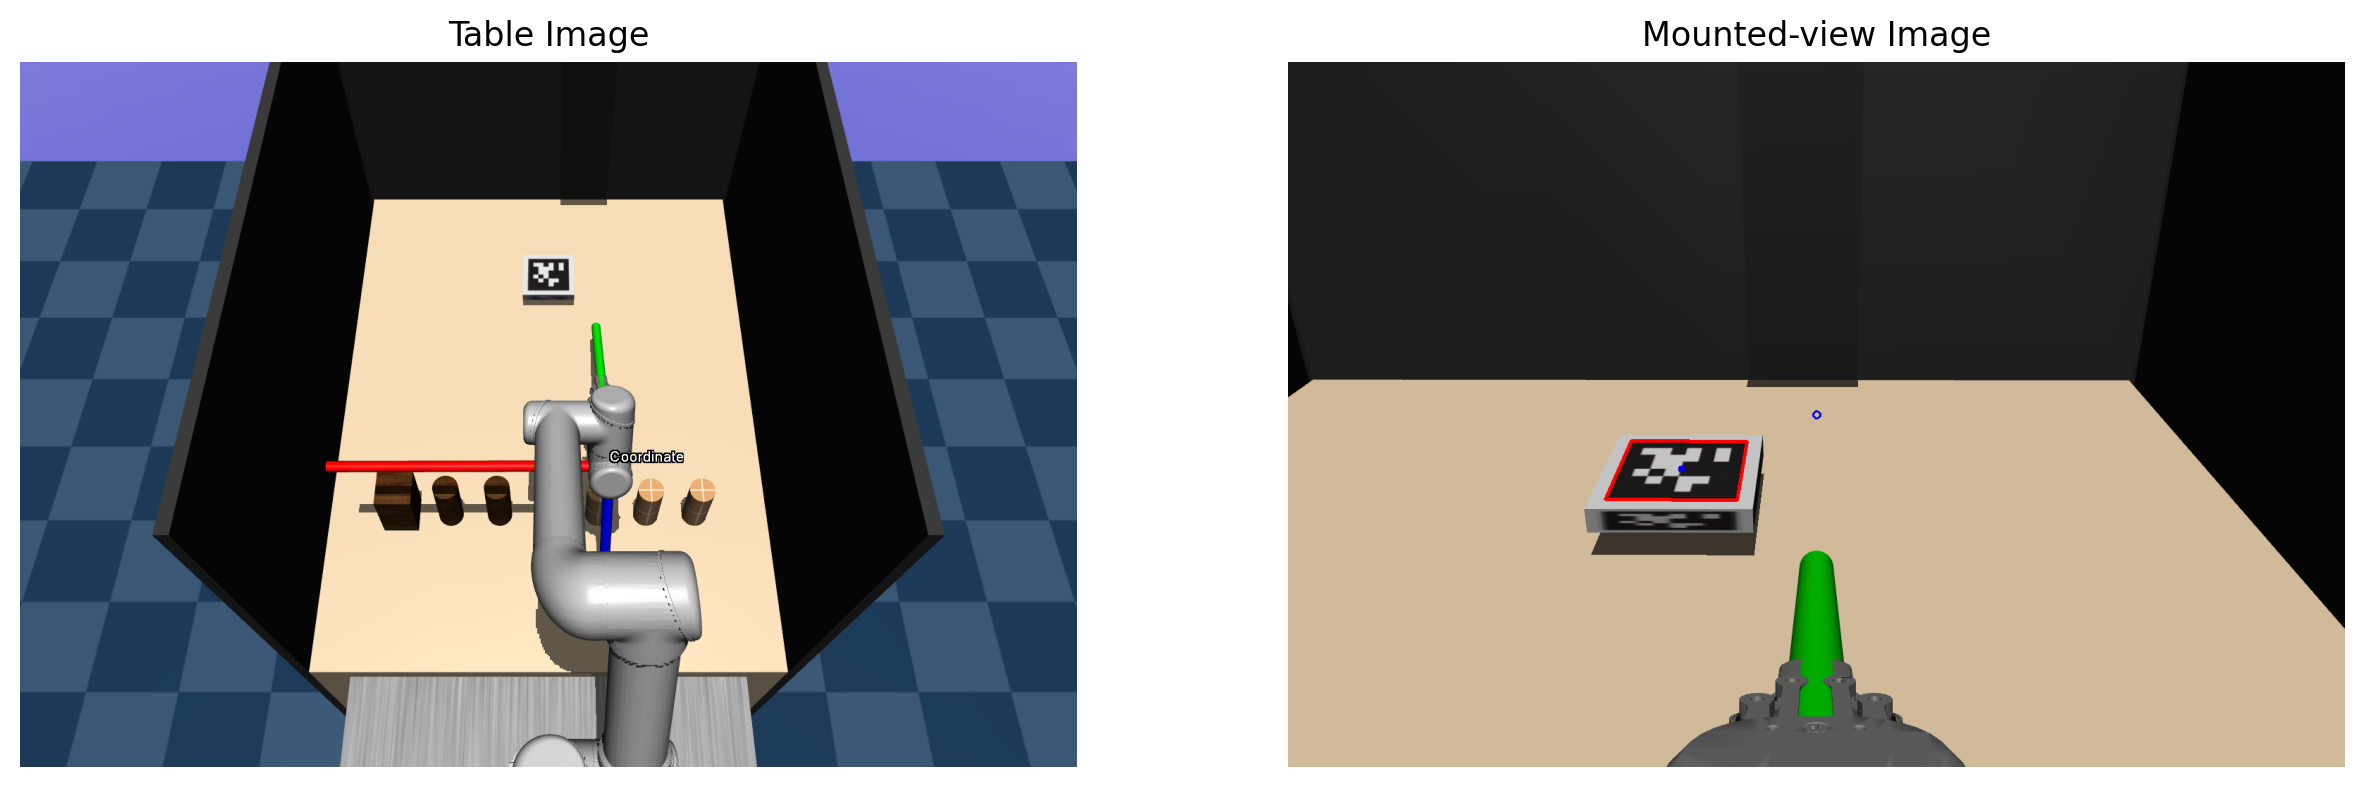

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.11111450195312, homography=array([[ 9.05e-01, -4.76e-01,  5.35e+00],
       [-2.83e-03,  3.52e-02,  5.89e+00],
       [ 1.52e-05, -6.65e-04,  1.02e-02]]), center=array([527.06, 579.78]), corners=array([[455.73, 541.93],
       [621.46, 539.89],
       [608.15, 622.8 ],
       [419.12, 625.39]]))]


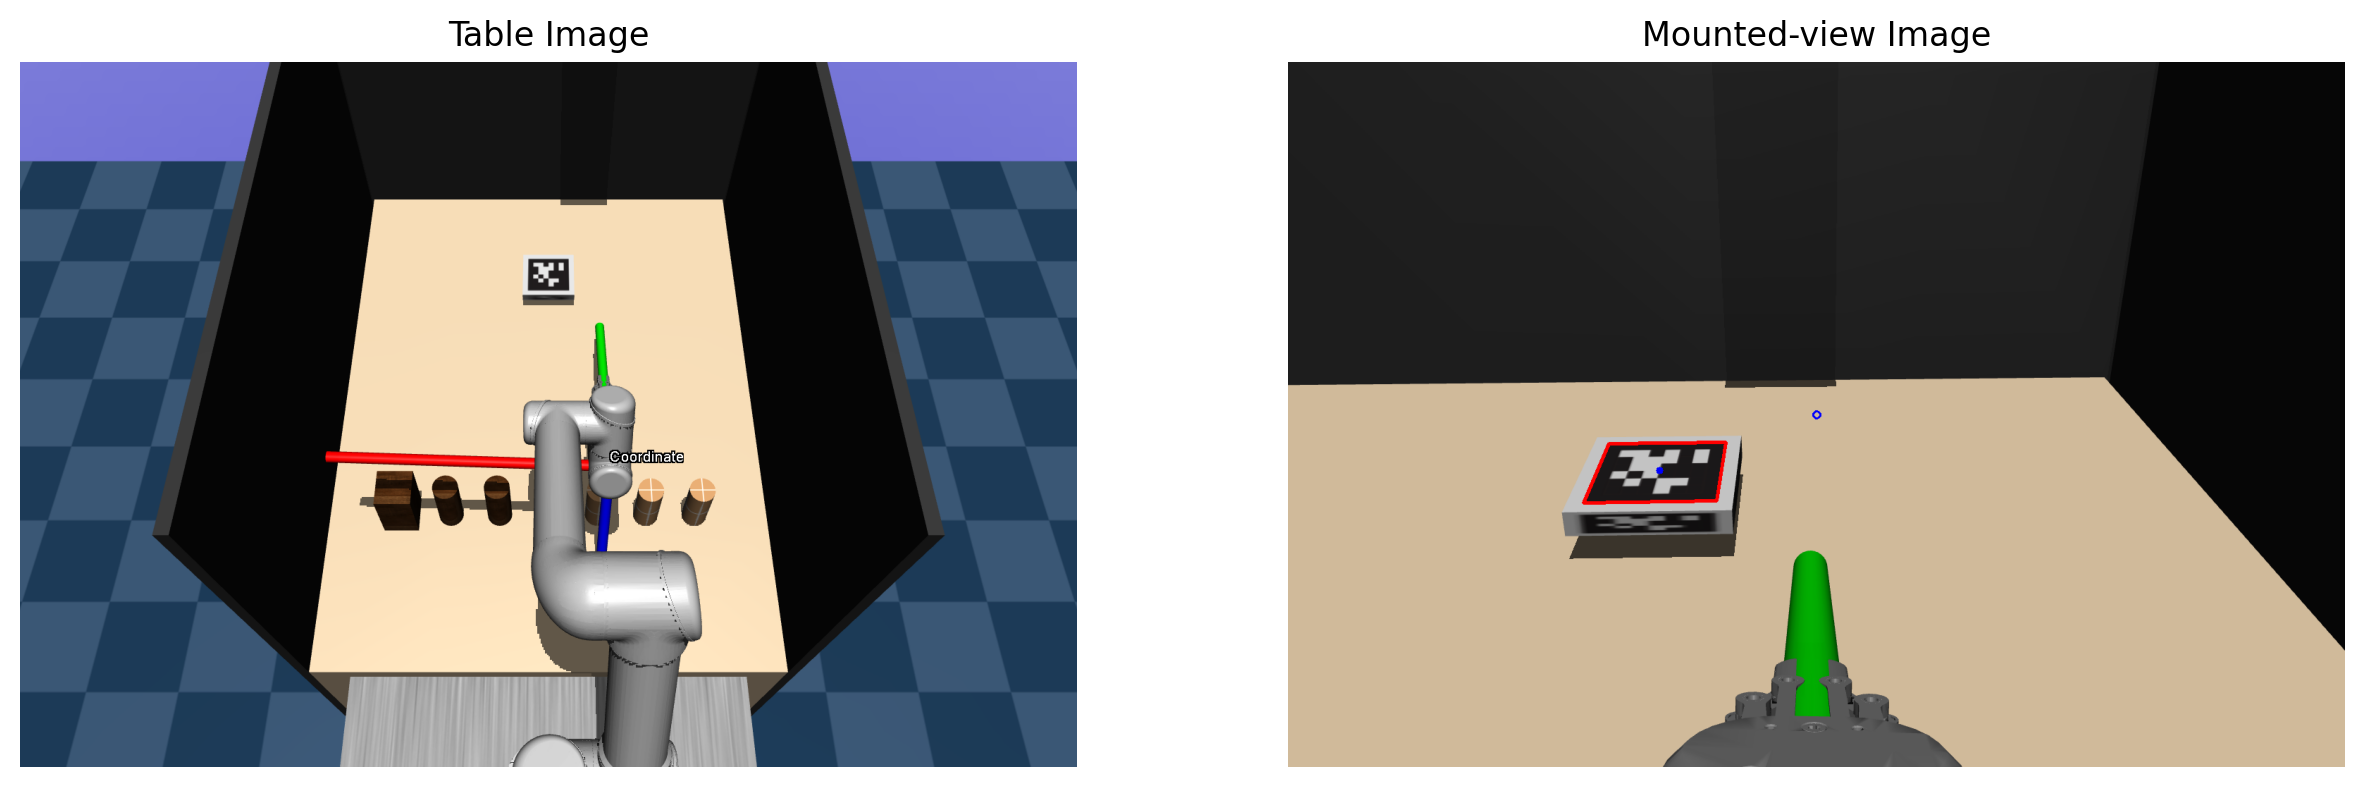

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.11111450195312, homography=array([[ 9.13e-01, -4.48e-01,  4.94e+00],
       [-2.97e-03,  3.67e-02,  5.86e+00],
       [ 3.34e-05, -6.58e-04,  1.01e-02]]), center=array([491.06, 582.88]), corners=array([[418.76, 545.62],
       [586.09, 541.68],
       [572.94, 625.08],
       [381.99, 630.17]]))]


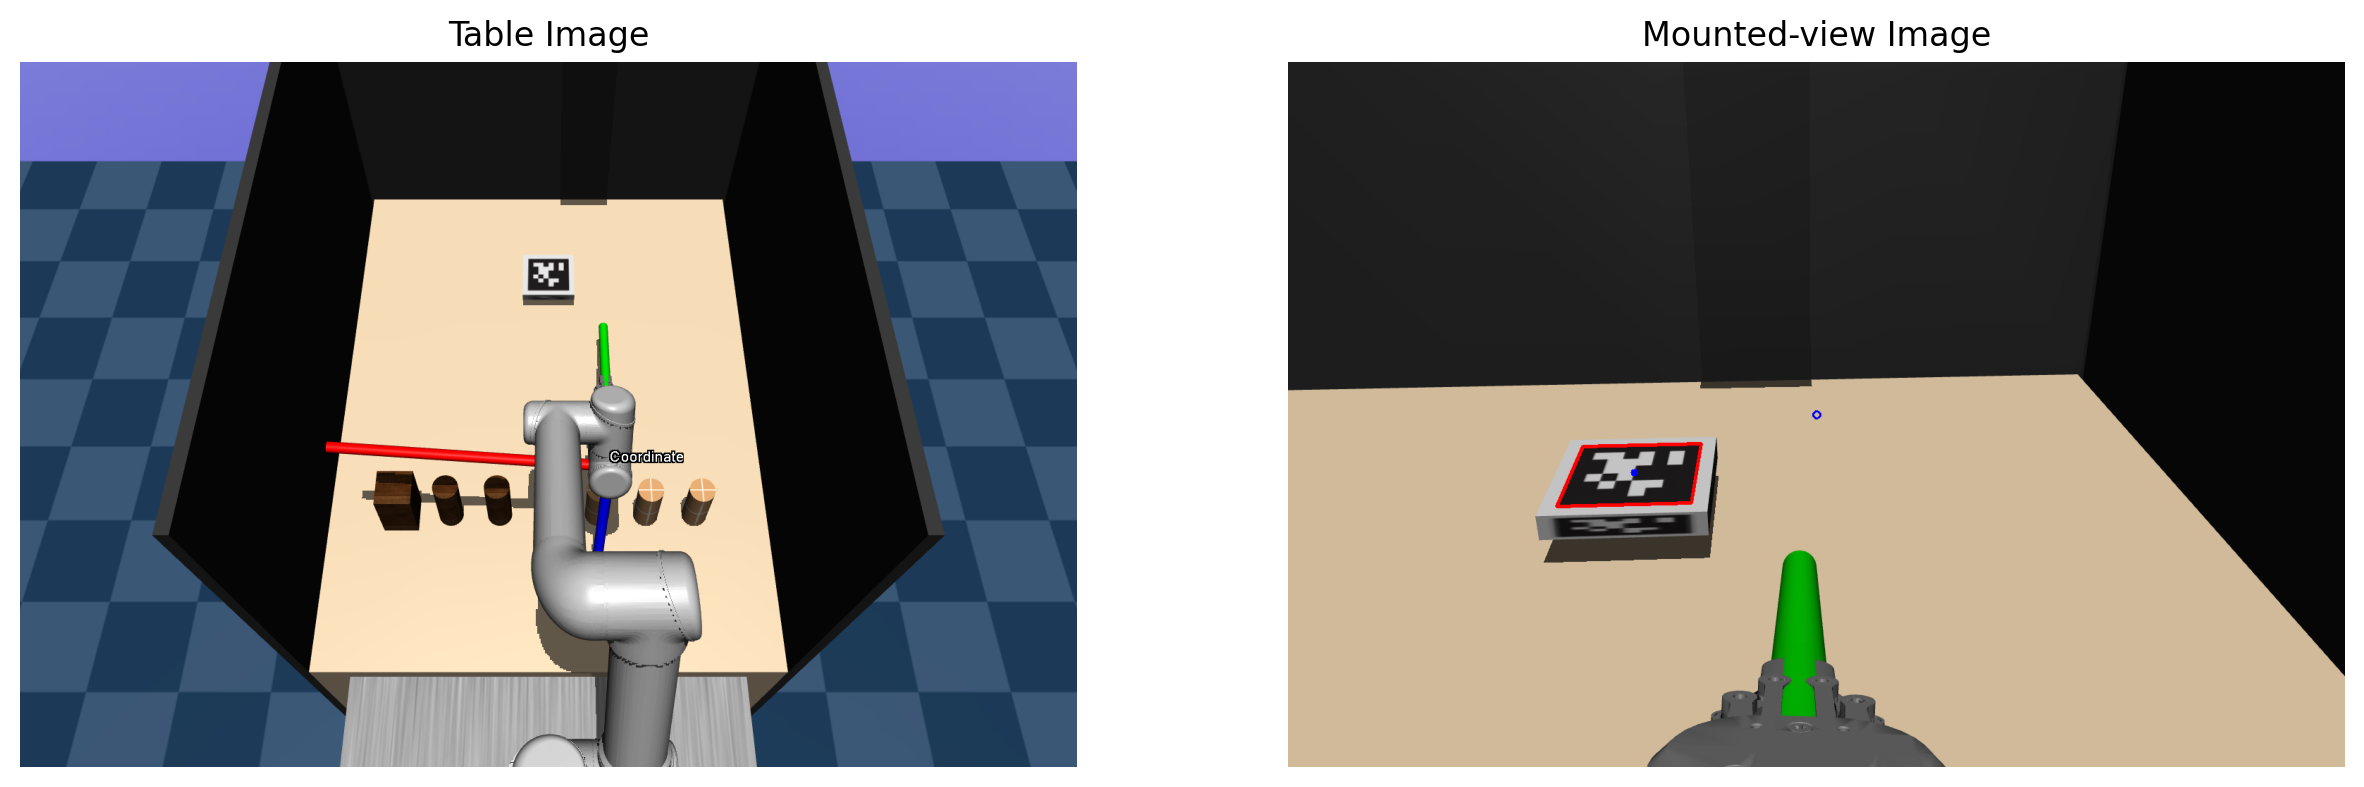

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.59998321533203, homography=array([[ 9.23e-01, -4.21e-01,  4.52e+00],
       [-1.59e-03,  3.61e-02,  5.83e+00],
       [ 5.61e-05, -6.54e-04,  9.94e-03]]), center=array([454.79, 586.21]), corners=array([[381.37, 549.68],
       [550.55, 543.59],
       [537.61, 627.43],
       [344.3 , 635.4 ]]))]


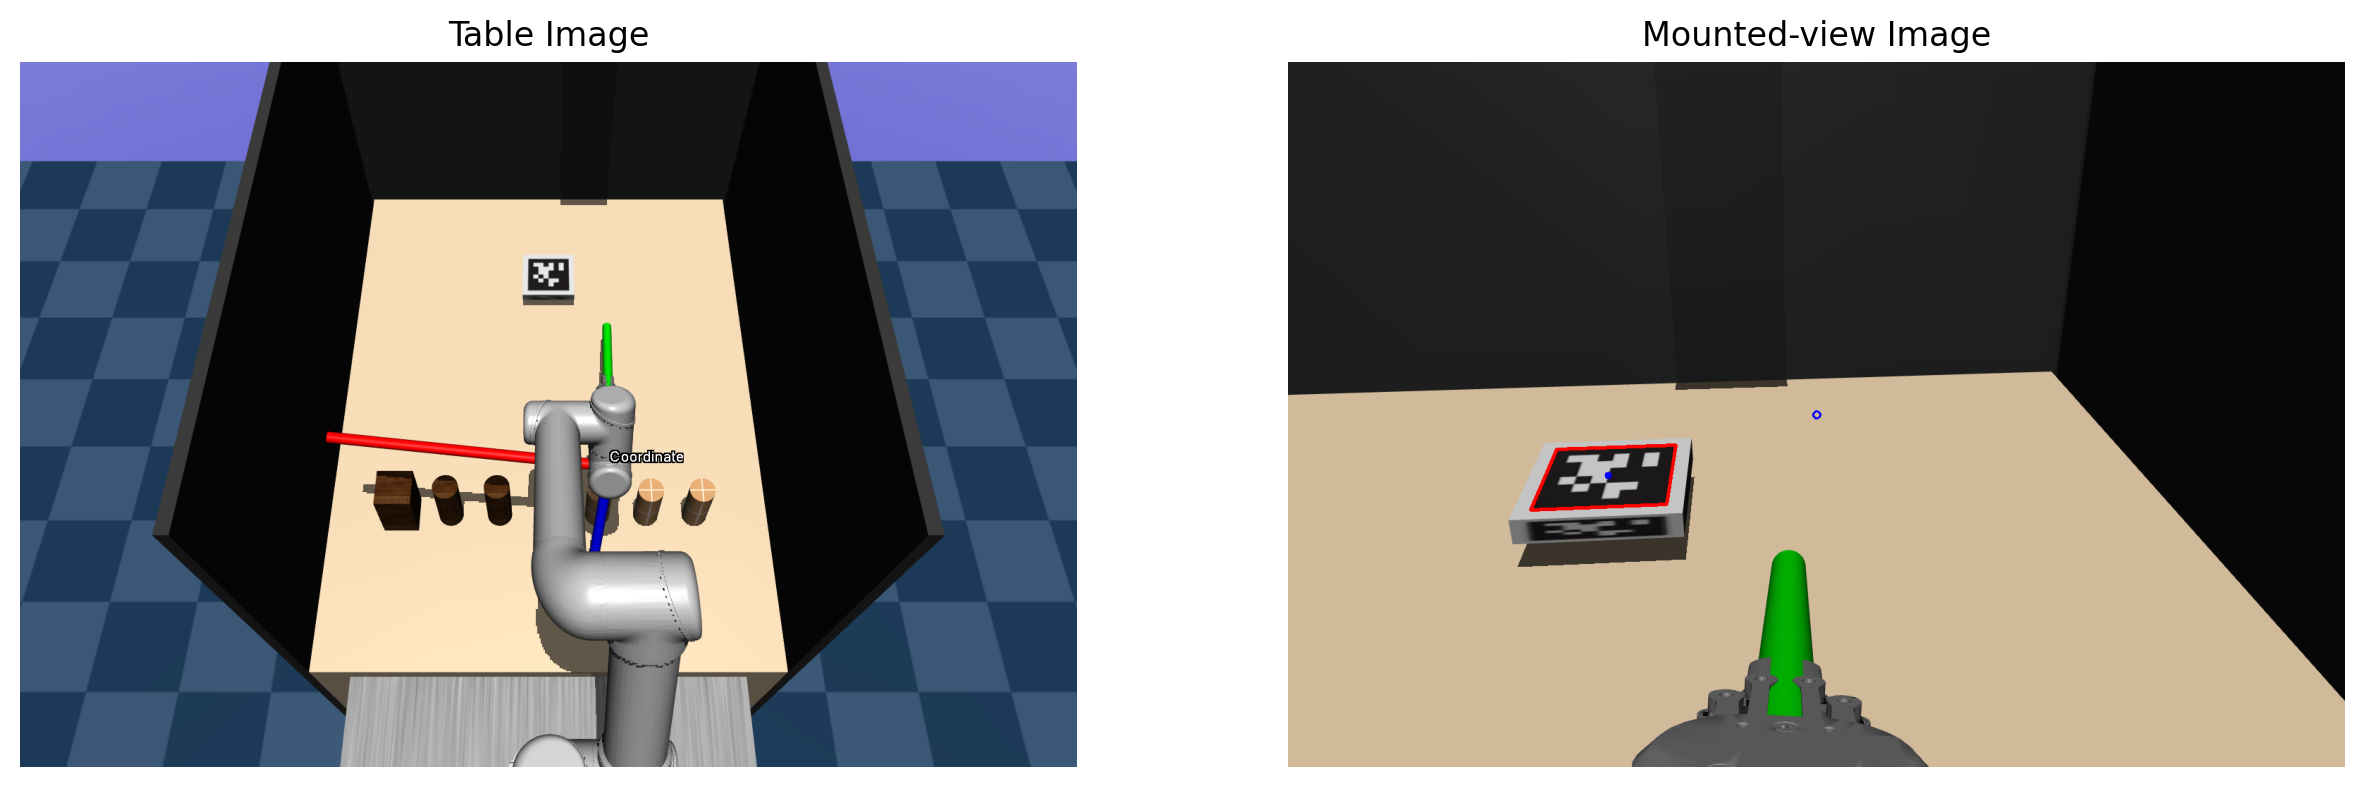

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.59998321533203, homography=array([[-9.28e-01,  3.93e-01, -4.10e+00],
       [ 2.71e-03, -3.61e-02, -5.79e+00],
       [-7.36e-05,  6.49e-04, -9.82e-03]]), center=array([418.1, 589.8]), corners=array([[343.49, 553.95],
       [514.75, 545.71],
       [501.98, 630.1 ],
       [306.09, 640.89]]))]


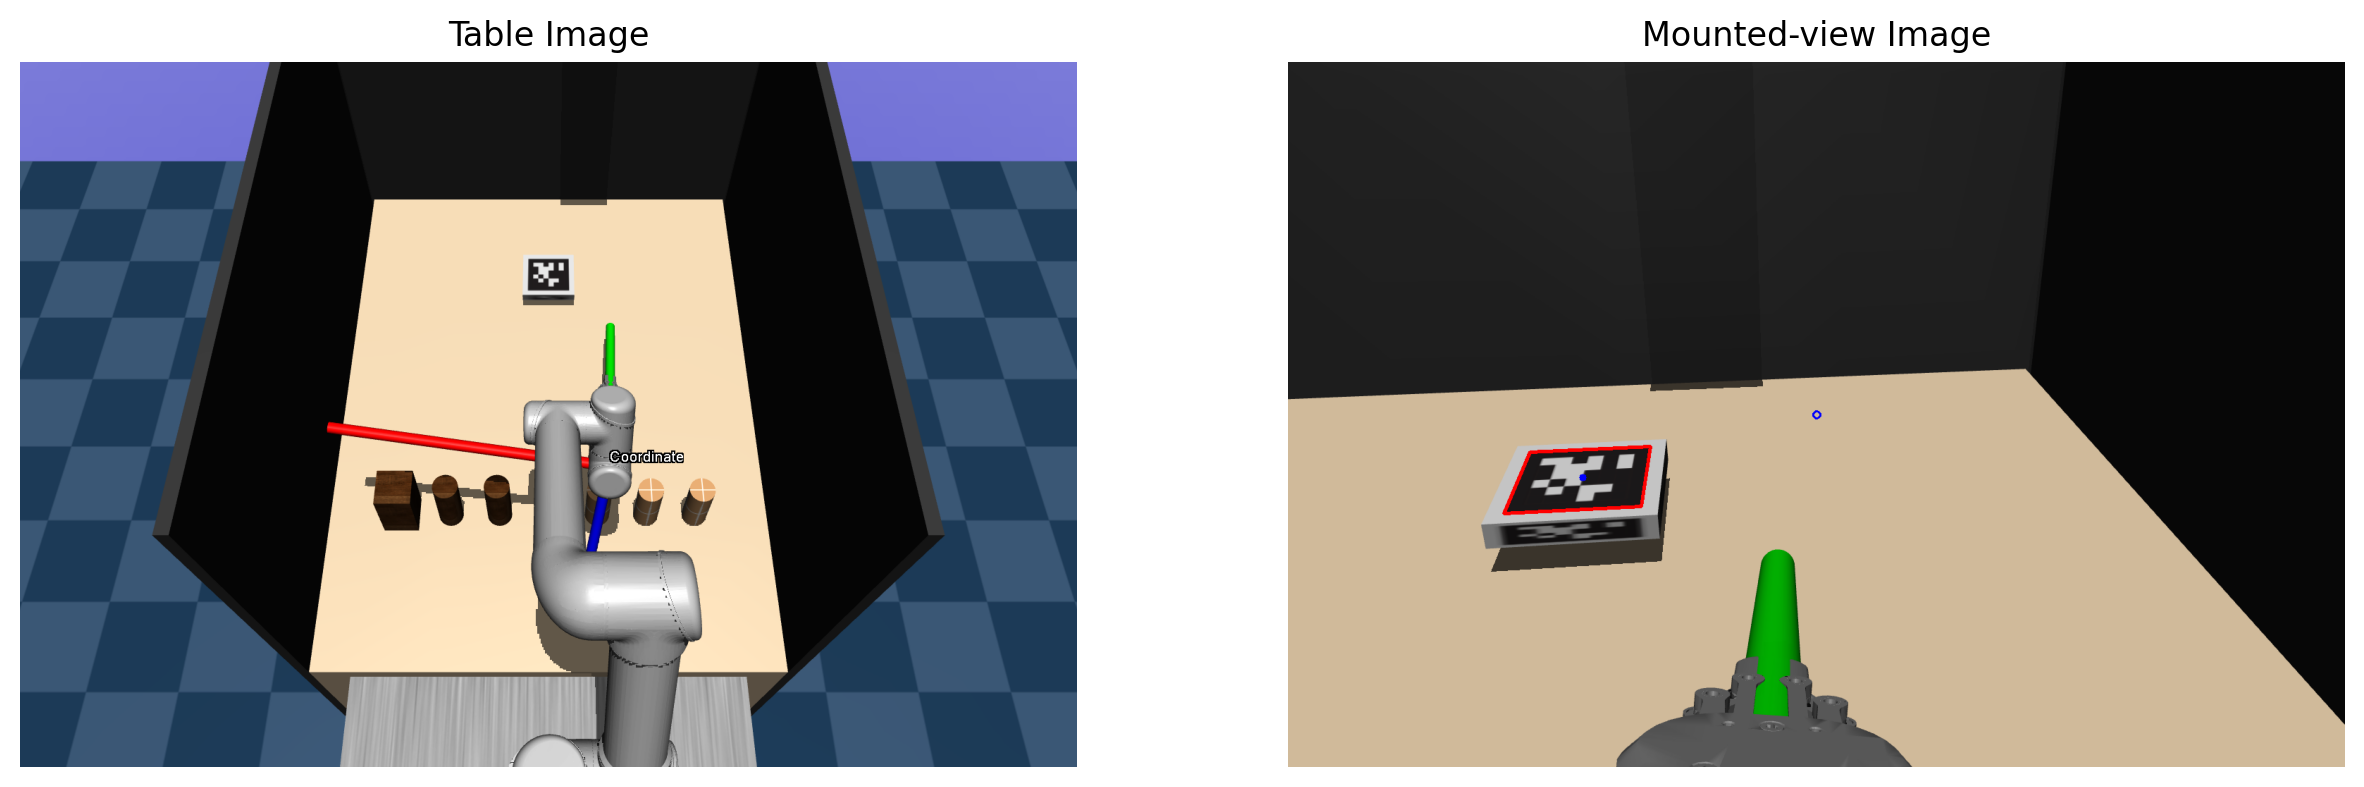

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.59998321533203, homography=array([[ 9.31e-01, -3.64e-01,  3.69e+00],
       [-5.15e-03,  3.75e-02,  5.75e+00],
       [ 8.87e-05, -6.39e-04,  9.68e-03]]), center=array([380.94, 593.68]), corners=array([[305.02, 558.56],
       [478.73, 548.05],
       [466.03, 633.04],
       [267.26, 646.73]]))]


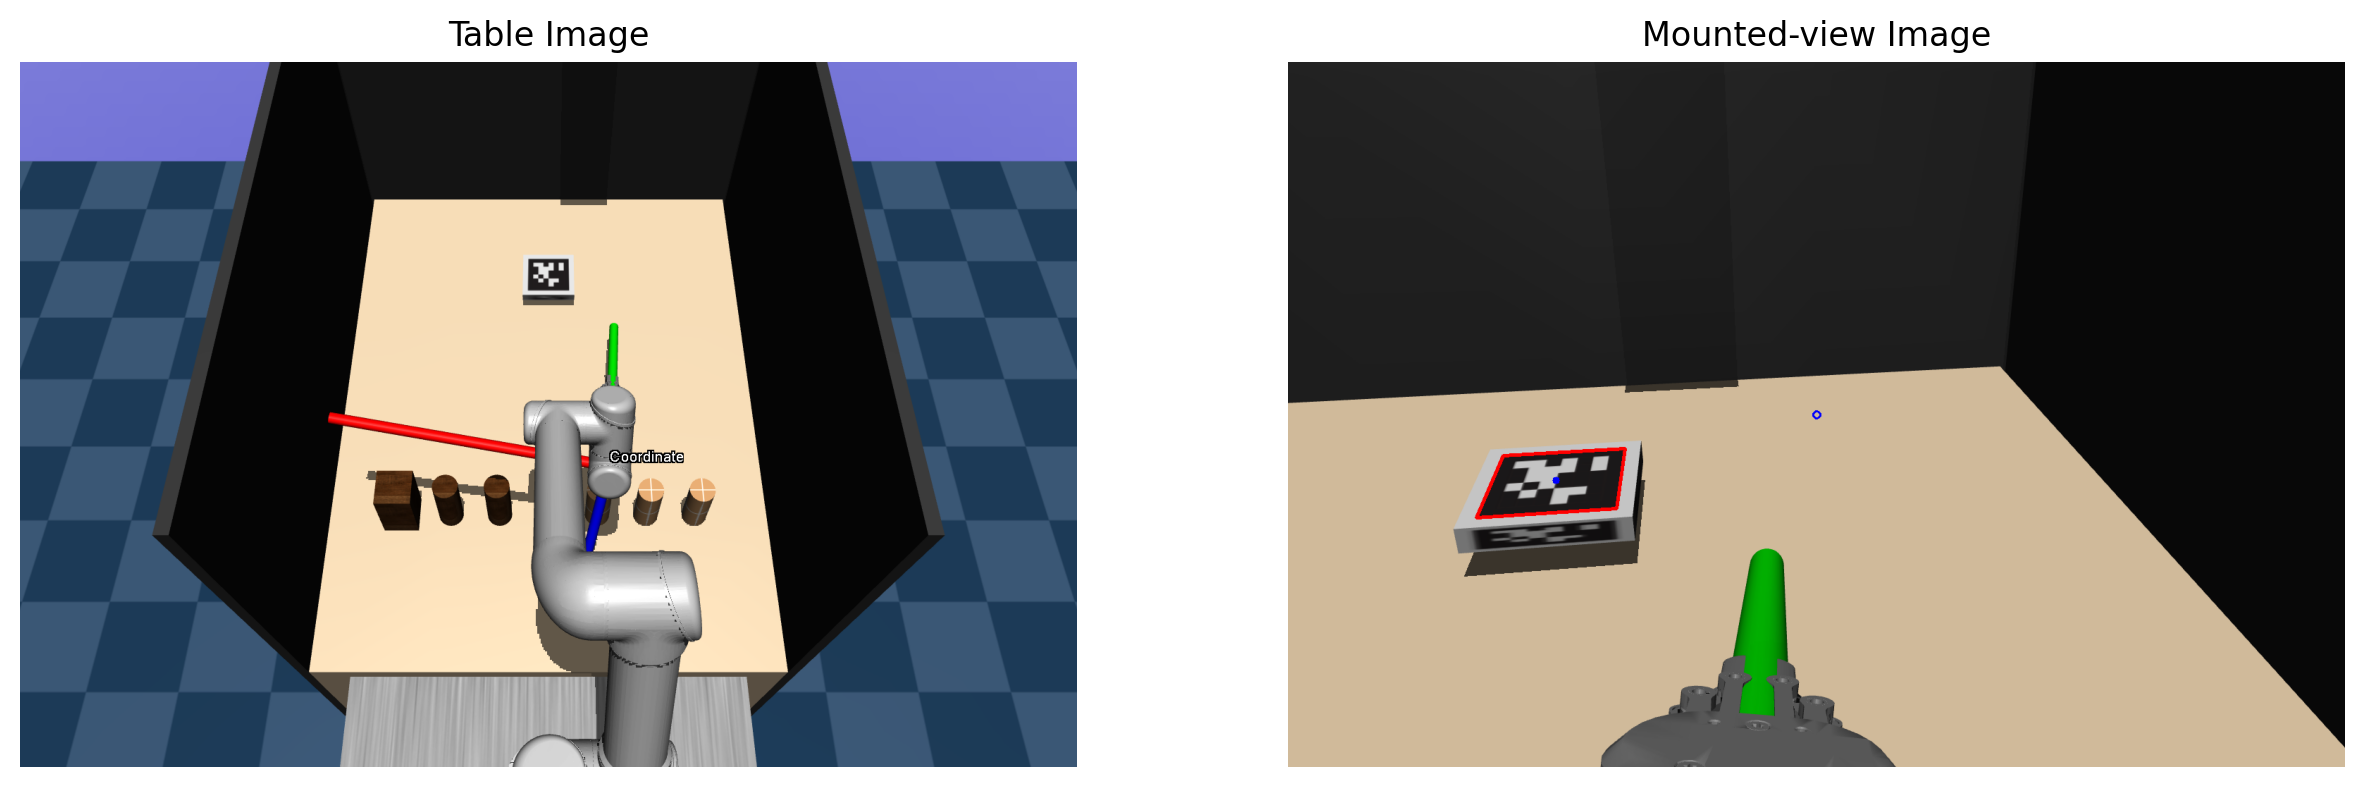

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.59998321533203, homography=array([[ 9.33e-01, -3.36e-01,  3.27e+00],
       [-6.48e-03,  3.64e-02,  5.70e+00],
       [ 1.05e-04, -6.34e-04,  9.53e-03]]), center=array([343.31, 597.82]), corners=array([[265.91, 563.42],
       [442.27, 550.63],
       [429.8 , 636.25],
       [227.71, 652.94]]))]


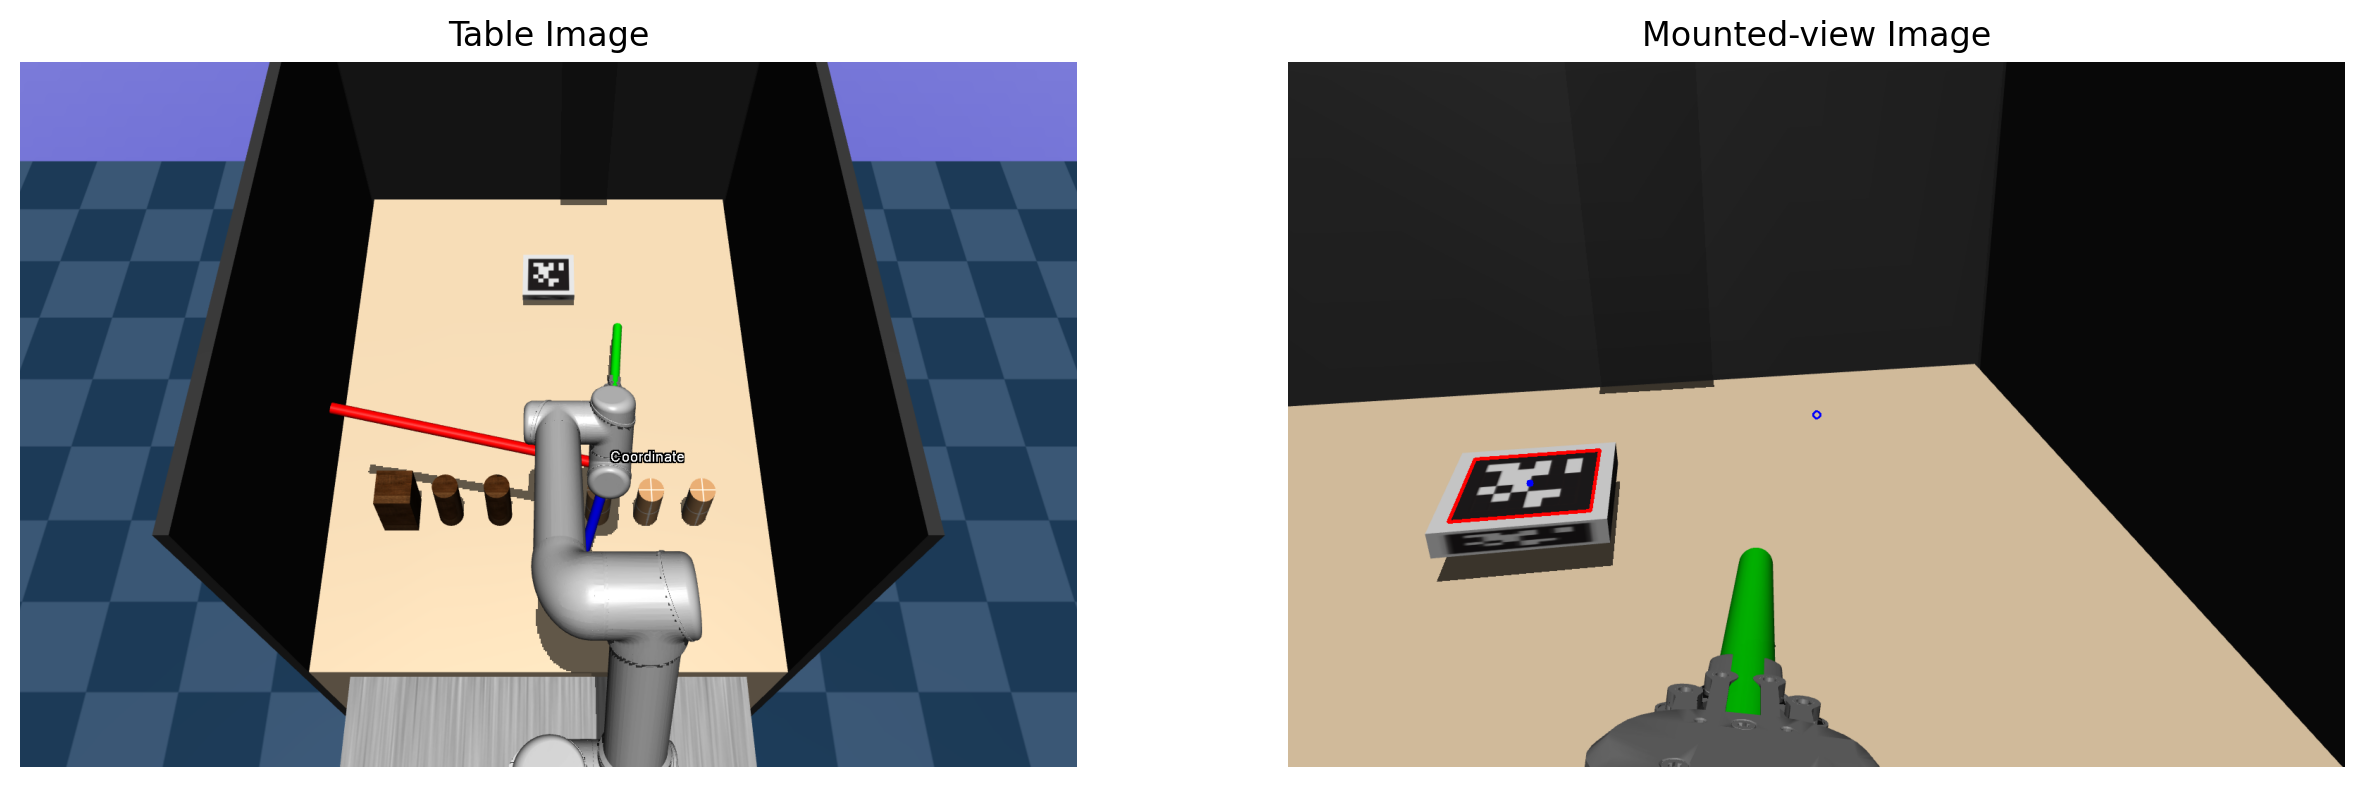

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.59998321533203, homography=array([[-9.36e-01,  3.07e-01, -2.86e+00],
       [ 5.51e-03, -3.82e-02, -5.64e+00],
       [-1.25e-04,  6.22e-04, -9.37e-03]]), center=array([305.17, 602.27]), corners=array([[226.11, 568.59],
       [405.51, 553.44],
       [393.09, 639.72],
       [187.43, 659.56]]))]


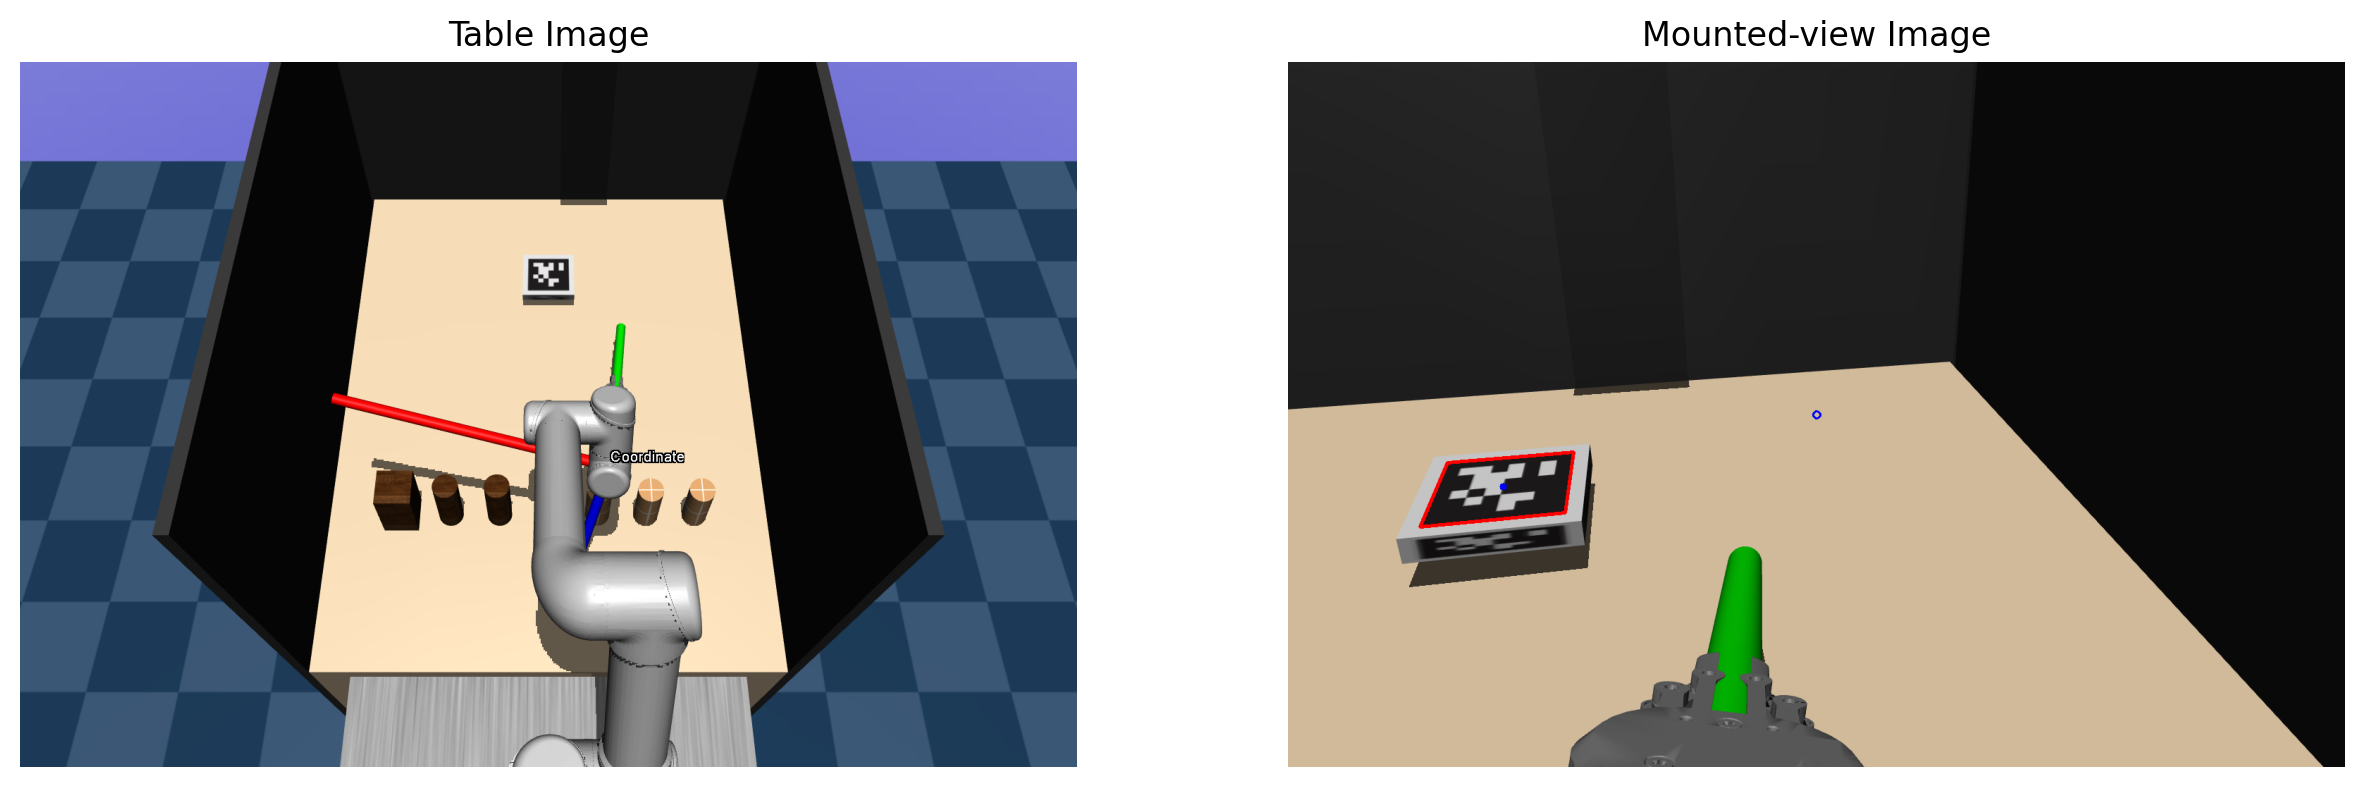

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.59998321533203, homography=array([[-9.35e-01,  2.80e-01, -2.45e+00],
       [ 7.90e-03, -3.66e-02, -5.58e+00],
       [-1.39e-04,  6.16e-04, -9.20e-03]]), center=array([266.28, 607.02]), corners=array([[185.47, 574.13],
       [368.1 , 556.49],
       [355.93, 643.51],
       [146.25, 666.58]]))]


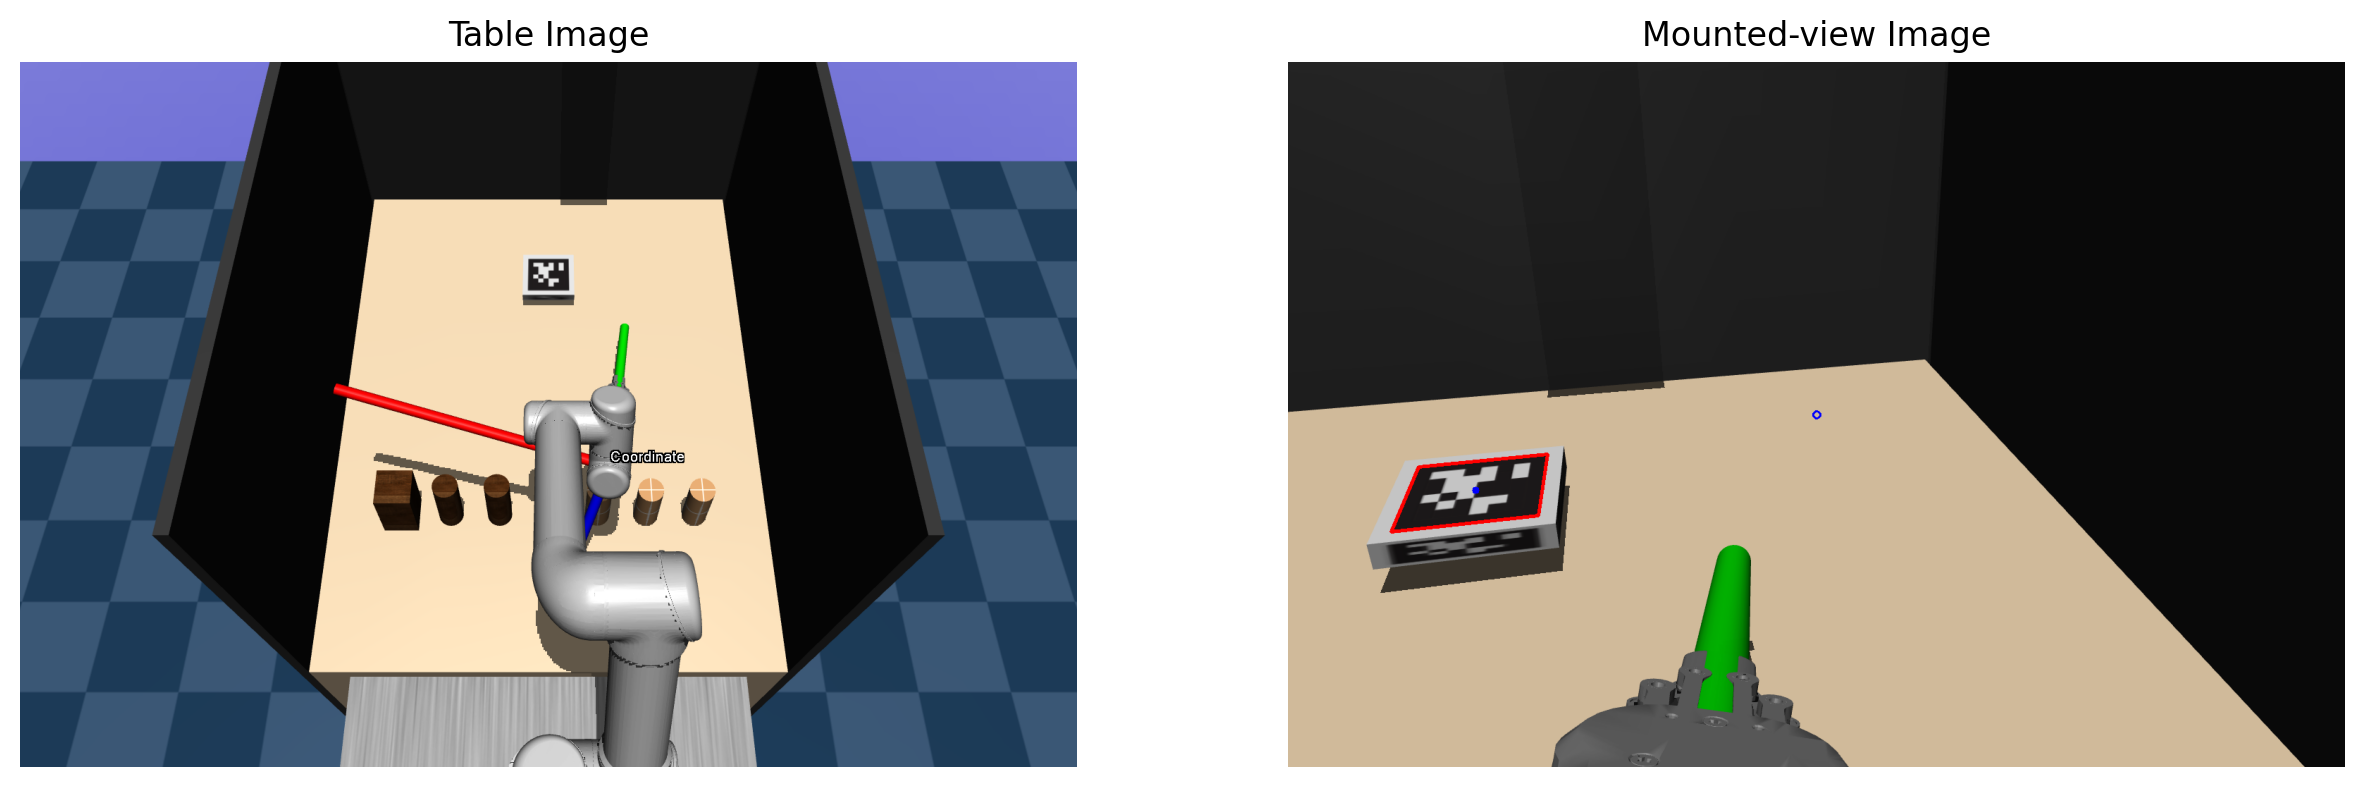

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=83.59998321533203, homography=array([[-9.33e-01,  2.50e-01, -2.04e+00],
       [ 9.46e-03, -4.05e-02, -5.52e+00],
       [-1.54e-04,  6.00e-04, -9.01e-03]]), center=array([226.7 , 612.15]), corners=array([[143.88, 580.03],
       [330.3 , 559.79],
       [318.13, 647.61],
       [104.19, 674.06]]))]


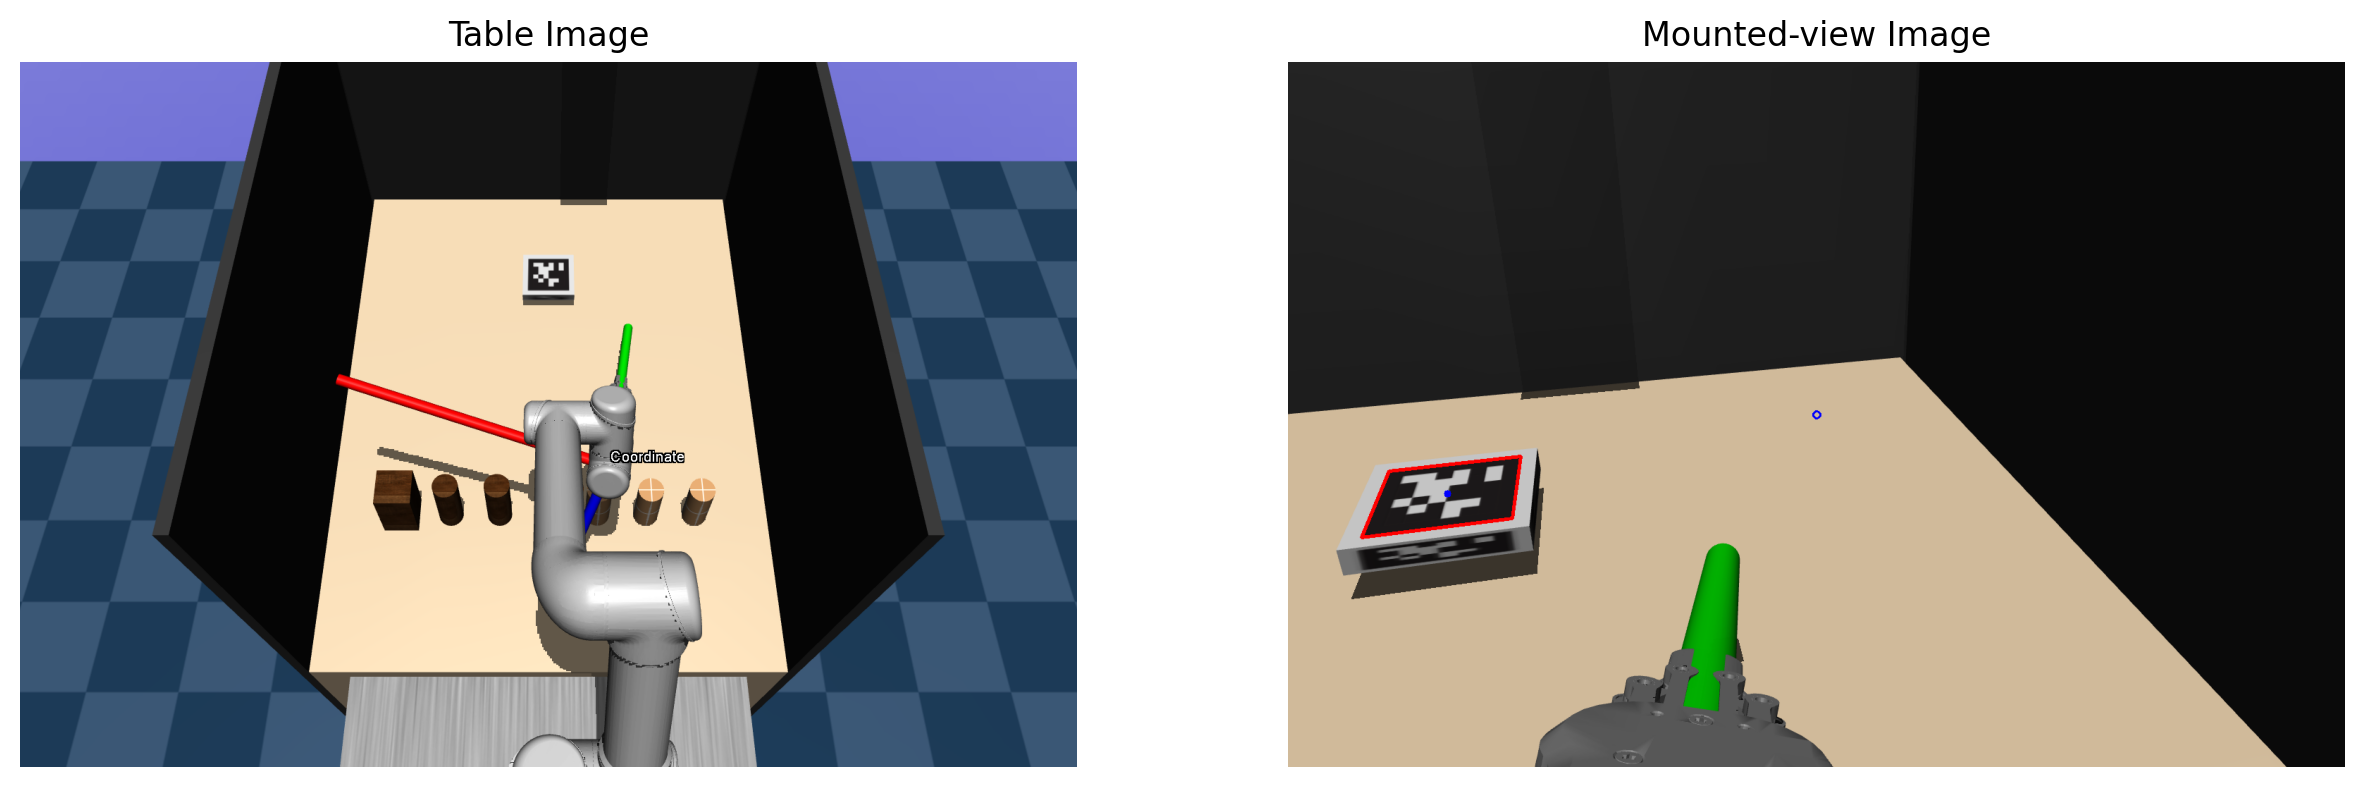

In [114]:
import math

bs2ee_list = []
tagpose_list = []
camera_pos_list = []
p_eef_list = []

# delete all the markers.
del env.viewer._markers[:]

# Check available objects whose names start with 'obj_'
# Set objects behind of apriltag
obj_names = get_env_obj_names(env,prefix='obj_') # see objects
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [0.7,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=None)

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

# update object, robot configurations
env.step()
env.forward(INCREASE_TICK=False)

max_tick = 10
env.tick = 0

while env.tick < max_tick:
    # Set Joint Configurations
    init_configurations = [-math.pi, -2.0, -math.pi/2, -math.pi, -math.pi/2+0.005*env.tick*math.pi, +0.01*env.tick*math.pi]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # update object, robot configurations
    env.step()
    env.forward(INCREASE_TICK=False)

    # Get pose what I want to attach on.
    p_eef = env.get_p_body("ur_wrist_3_link")
    R_eef = env.get_R_body("ur_wrist_3_link")
    p_eef_list.append(p_eef)
    
    axis_len = 0.18
    p_z = p_eef - R_z[:,2]*axis_len/2
    R_z = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))

    # Add viewer coordinate marker.
    env.add_marker_coordinate(
        p=p_eef,R=R_eef,axis_len=0.5,axis_width=0.01,label='Coordinate')

    R_z_rpy = np.degrees(r2rpy(R_z))
    
    # View Up-right the table.
    cam_table = env.set_cam_infos(cam_distance  = 1.0,
                        cam_azimuth   = 0,   # Z-axis: Yaw
                        cam_elevation = -60,      # X-axis: Roll                        
                        cam_lookat    = [0.5, 0, 1.5])  # arbitrary offset on camera.

    for _ in range(5):
        img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(img_table); plt.axis('off')
    plt.title("Table Image")

    # Follow Robot end-effector.
    cam_infos = env.set_cam_infos(cam_distance  = 0.00,
                        cam_azimuth   = R_z_rpy[2]+90,        # Z-axis: Yaw
                        cam_elevation = R_z_rpy[0]+180,      # X-axis: Roll                        
                        cam_lookat    = p_z)  # arbitrary offset on camera.

    camera_pos_list.append(cam_infos["cam_lookat"])

    env.forward(INCREASE_TICK=False)

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth2meters(img_depth))

    detector = apriltag.Detector()
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
    results = detector.detect(img_Gray)
    print(results)
    draw_bbox(results, img, verbose=False)


    plt.subplot(1,2,2)
    plt.imshow(img); plt.axis('off')
    plt.title("Mounted-view Image")
    plt.show()

    # Get matrix A.
    tagpose = get_apriltag_pose(env, img, img_depth)
    tagpose_list.append(tagpose)

    # Get matrix B.
    bs2ee_matrix = get_homogeneous_matrix(env, from_link='ur_base_link', to_link='ur_rg2_gripper_base_link', verbose=False)
    bs2ee_list.append(bs2ee_matrix)

    # delete all the markers.
    del env.viewer._markers[:]

    img = []
    cam_infos = []

In [115]:
import sys
sys.path.append("..")
from util_calibration import get_extrinsic_calibration_frank, get_extrinsic_calibration_tsai

In [116]:
A = bs2ee_list
B = tagpose_list

In [117]:
get_extrinsic_calibration_frank(A, B)

array([[ 0.66, -0.1 , -0.74,  0.77],
       [-0.63, -0.62, -0.47, -0.17],
       [ 0.41, -0.78,  0.48, -0.04],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [118]:
get_extrinsic_calibration_tsai(A, B)

array([[ 0.51, -0.73, -0.45,  0.55],
       [-0.64,  0.02, -0.77,  0.19],
       [ 0.57,  0.68, -0.45, -0.03],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [92]:
camera_pos_list

[array([ 0.71, -0.13,  1.1 ]),
 array([ 0.71, -0.11,  1.1 ]),
 array([ 0.71, -0.11,  1.1 ]),
 array([ 0.71, -0.12,  1.1 ]),
 array([ 0.71, -0.13,  1.1 ])]

In [93]:
p_eef_list

[array([ 0.67, -0.11,  1.02]),
 array([ 0.67, -0.11,  1.02]),
 array([ 0.67, -0.11,  1.02]),
 array([ 0.67, -0.11,  1.02]),
 array([ 0.67, -0.11,  1.02])]

In [85]:
ground_truth = [camera_pos_list[i] - p_eef_list[i] for i in range(8)]
ground_truth

IndexError: list index out of range